## Librairies

In [13]:
from gymnasium import Env
import gymnasium
import numpy as np
import os
from stable_baselines3.common import env_checker
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from gymnasium.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete
from cargame import Car, Track, Vector
import pygame
import sys
import matplotlib.pyplot as plt


## Load Environment

In [14]:
def plot_car(background, car_position_pixels, size) -> None:
    fig, ax = plt.subplots()
    ax.imshow(background, cmap='gray')
    ax.plot(car_position_pixels.x,car_position_pixels.y, 'yo', markersize = size)
    plt.title('Binary Road Mask')
    plt.axis('off')  
    plt.show()

In [15]:
from time import time
from imageprocessing import image

class CarEnvironment(Env):
    MAX_EPOCH_TIME = 3 * 60

    def __init__(self,
                 ):
        self.action_space = Box(low=np.array([0, -1.0]), high=np.array([1.0, 1.0]), shape = (2,), dtype = np.float32)

        print("Loading pixels from image")
        pixels = image.transform_image('imageprocessing/image_test/test3redgreen.png')
        print(pixels.shape)
        plt.imshow(pixels, cmap='gray') 

        print("Creating track")
        track = Track(pixels)
        self.timestep = 0.1
        
        print("Creating Car")
        self.car = Car(12, 15, 0.5, 70, track, 0.05, Vector(0, 7), Vector(4.5, -5))

        print("Making observation space")
        cm_per_pixel = self.car.body_length / track.car_dimensions.y
        self.observation_space = Dict({
            'GridR' : Box(low = 0, high = 255, shape = (pixels.shape[1], pixels.shape[0]), dtype=np.uint8),
            'GridG' : Box(low = 0, high = 255, shape = (pixels.shape[1], pixels.shape[0]), dtype=np.uint8),
            'GridB' : Box(low = 0, high = 255, shape = (pixels.shape[1], pixels.shape[0]), dtype=np.uint8),
            'CarPositionX' : Box(low = 0, high = pixels.shape[1] * cm_per_pixel, shape=(1,1)),
            'CarPositionY' : Box(low = 0, high = pixels.shape[0] * cm_per_pixel, shape=(1,1)),
            'CarSpeed' : Box(low = 0, high = 1, shape = (1,1)),
            'CarAngle' : Box(low = 0, high = 1, shape = (1,1)),
            'TireAngle' : Box(low = -1, high = 1, shape = (1,1))
        })

        grid_size = self.observation_space['GridR'].shape[0] * self.observation_space['GridR'].shape[1] * 3 
        one_dimension_size = 5
        
        print("Making flat observation space")
        self.observation_space = Box(
            low = np.concatenate([
                self.observation_space['GridR'].low.flatten(),
                self.observation_space['GridG'].low.flatten(),
                self.observation_space['GridB'].low.flatten(),
                self.observation_space['CarPositionX'].low.flatten(), 
                self.observation_space['CarPositionY'].low.flatten(),
                self.observation_space['CarSpeed'].low.flatten(),
                self.observation_space['CarAngle'].low.flatten(), 
                self.observation_space['TireAngle'].low.flatten() 
            ]),
                
            high = np.concatenate([
                self.observation_space['GridR'].high.flatten(), 
                self.observation_space['GridG'].high.flatten(), 
                self.observation_space['GridB'].high.flatten(), 
                self.observation_space['CarPositionX'].high.flatten(),
                self.observation_space['CarPositionY'].high.flatten(),
                self.observation_space['CarSpeed'].high.flatten(), 
                self.observation_space['CarAngle'].high.flatten(), 
                self.observation_space['TireAngle'].high.flatten()                            
            ]),
            shape = (grid_size + one_dimension_size,)
        )

        self.start_time = time()
    
    def step(self, action):
        print("Reward:", self.car.reward)
        # Apply Action 
        angle = action[1]
        speed = action[0]

        # Action
        self.car.set_front_tire_angle(angle)
        self.car.set_speed(speed)
        self.car.update()
        
        print(self.car.angle)
        print(self.car.tire_angle)
        plot_car(self.car.track.pixels, self.car.get_pixel_position(), self.car.track.car_dimensions.x)
        
        # Terminated
        truncated = (time() - self.start_time) > CarEnvironment.MAX_EPOCH_TIME
        return self.car.get_state(), self.car.reward, self.car.check_if_done() or self.car.check_if_terminated(), truncated, {}
    
    def reset(self, seed=10):
        self.car.reset()
        self.start_time = time()
        plot_car(self.car.track.pixels, self.car.get_pixel_position(), self.car.track.car_dimensions.x)


        return (self.car.get_state(), {})
    
    def render(self):
        screen = pygame.display.set_mode((4000,3000))
    
        while True:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
                    sys.exit()

    def close(self) -> None:
        pass

## Train RL Model

Loading pixels from image
(96, 96, 3)
Creating track
Getting Start Pixel List
Got Start Pixel List
Creating Car
Making observation space
Making flat observation space


/Users/jeffbrin/.local/lib/python3.12/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/jeffbrin/.local/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


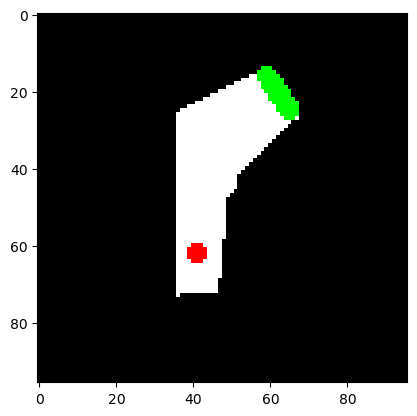

In [16]:
env = CarEnvironment()
# env = DummyVecEnv([lambda : env])

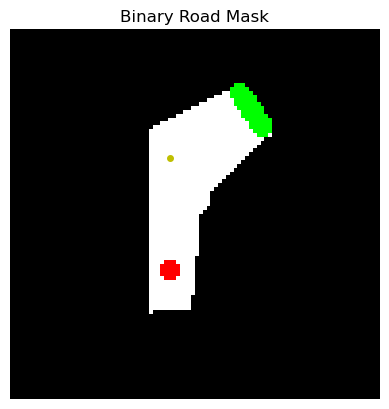

/Users/jeffbrin/.local/lib/python3.12/site-packages/stable_baselines3/common/env_checker.py:461: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


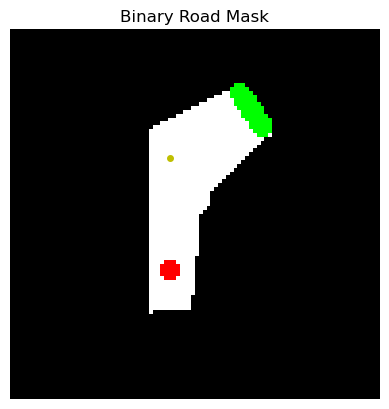

Reward: 200
48.22640609381568
7.5895750522613525


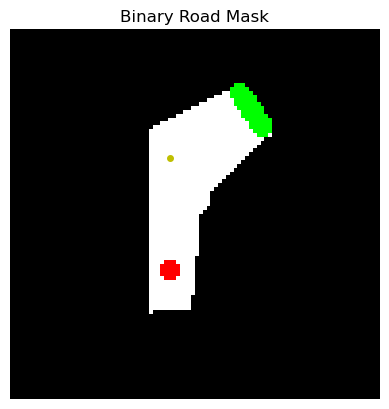

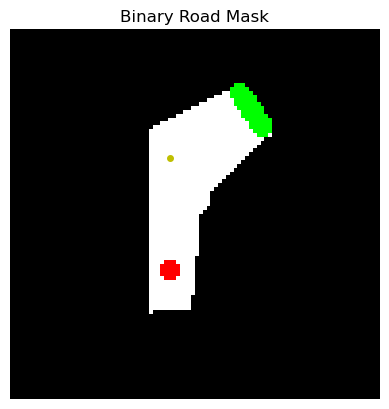

Reward: 200
150.99223704258327
-27.03312635421753


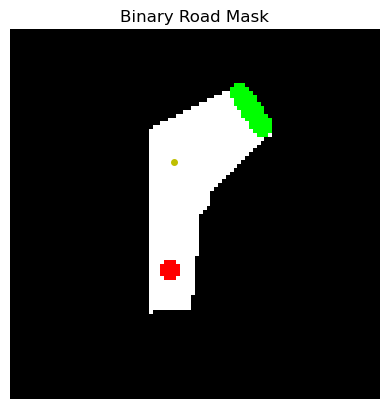

Reward: 199
23.23922736422736
27.842745780944824


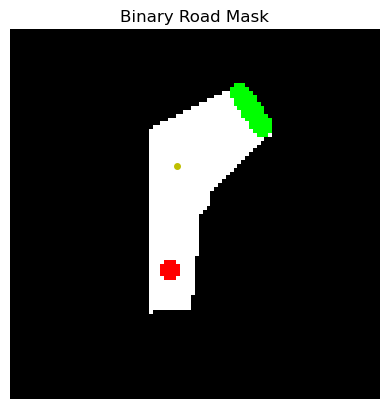

Reward: 198
57.58923213339128
17.965131998062134


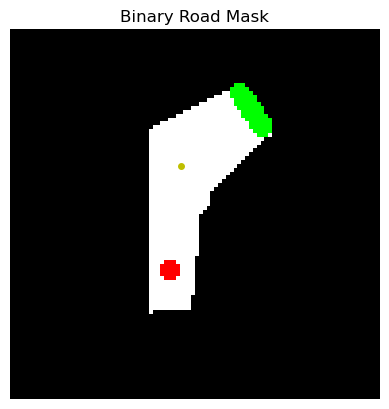

Reward: 197
-177.3637295454189
4.647058546543121


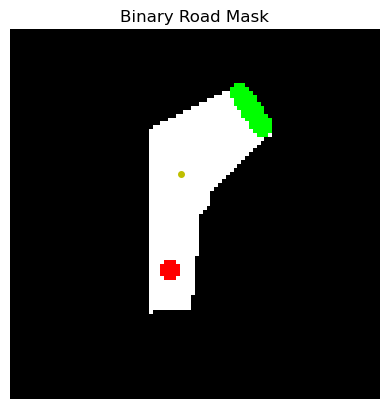

Reward: 196
-243.0044764548355
12.259933948516846


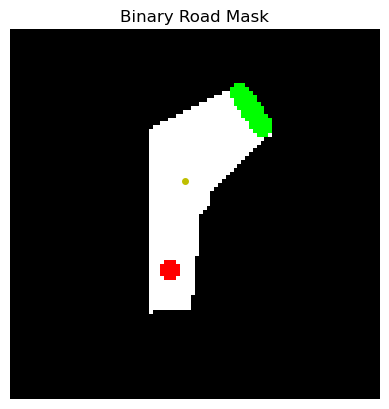

Reward: 195
-47.59684599189751
-11.653764545917511


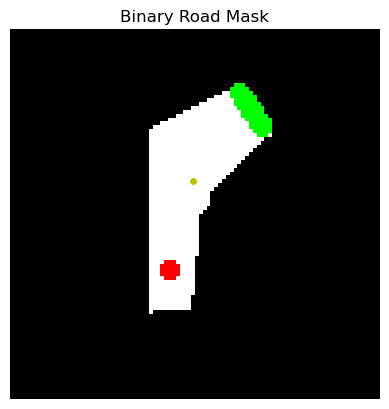

Reward: 194
-184.2192344723527
21.749151349067688


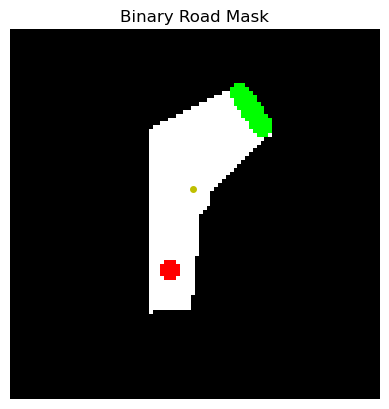

Reward: 193
-44.14299993623095
-26.397237181663513


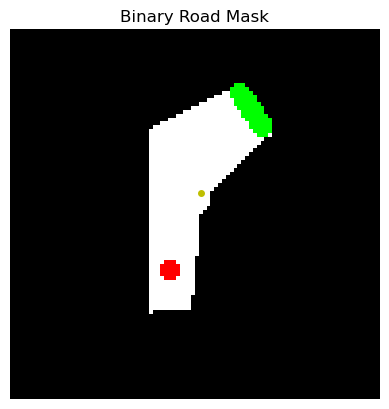

Reward: 192
70.28385587078797
-1.1126434430480003


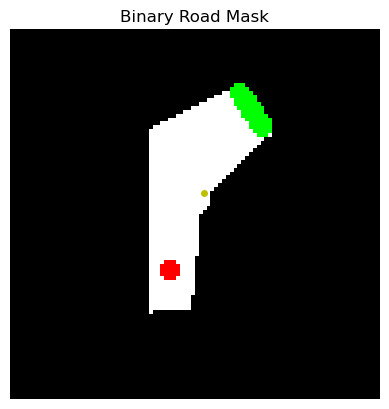

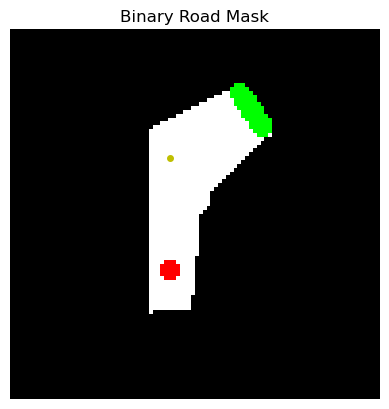

Reward: 200
-253.64477754087832
21.17117464542389


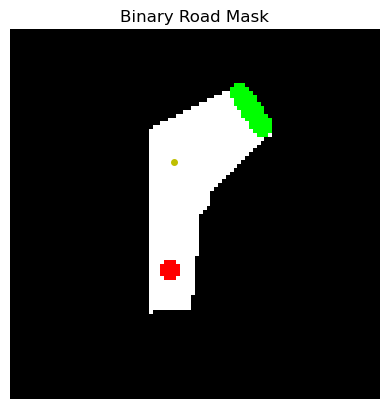

In [17]:
env_checker.check_env(env, warn=True, skip_render_check=True)

In [18]:
log_path = os.path.join('Training', 'Logs')
# model = PPO('CnnPolicy', env, verbose = 1, tensorboard_log=log_path)
model = PPO('MlpPolicy', env, verbose = 2, tensorboard_log=log_path, n_steps=50)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/Users/jeffbrin/.local/lib/python3.12/site-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 50`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 50
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=50 and n_envs=1)
  warnings.warn(


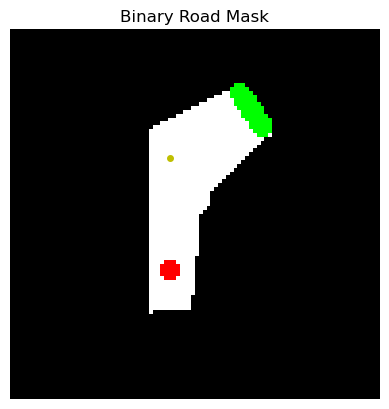

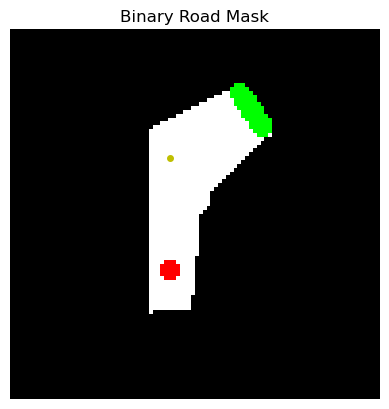

Logging to Training/Logs/PPO_45


Output()

Reward: 200

255.85271202963594

-0.06994854658842087

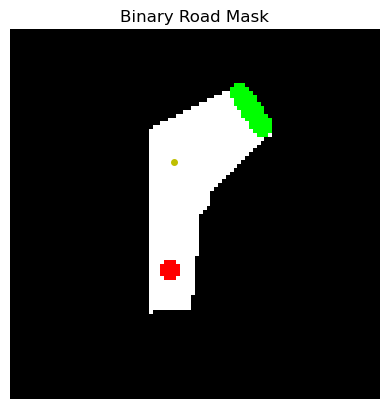

Reward: 199

-155.15241908856945

7.833369076251984

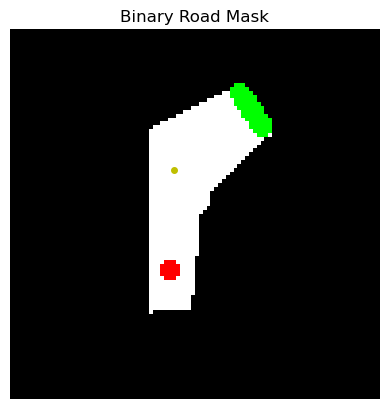

Reward: 198

-154.49940259150407

10.442648828029633

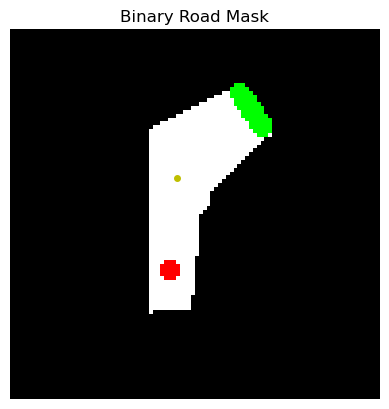

Reward: 197

-129.6062423545229

16.507295966148376

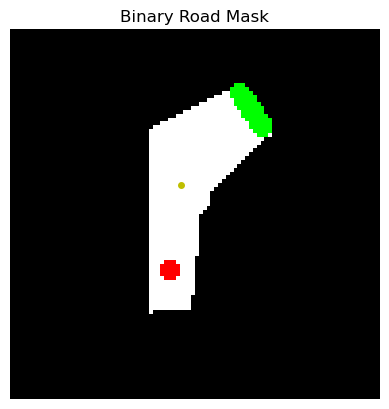

Reward: 196

-1.4548423895789995

-30.0

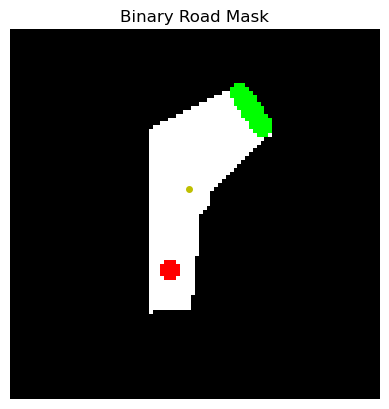

Reward: 195

-132.2504104486914

20.49675464630127

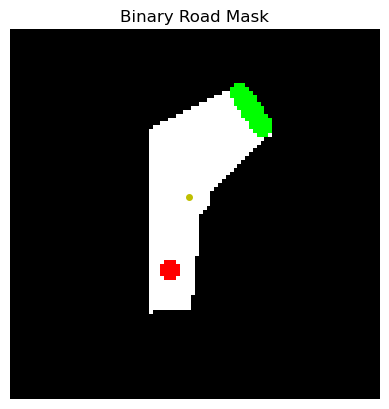

Reward: 194

-11.361872104038596

-14.961168766021729

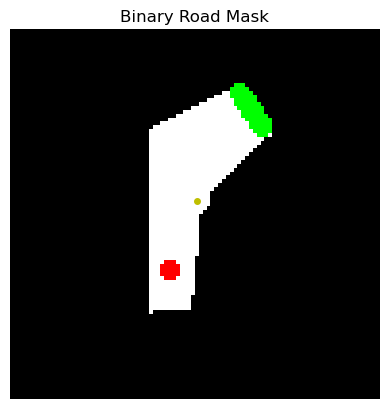

Reward: 193

-66.62039196648718

-30.0

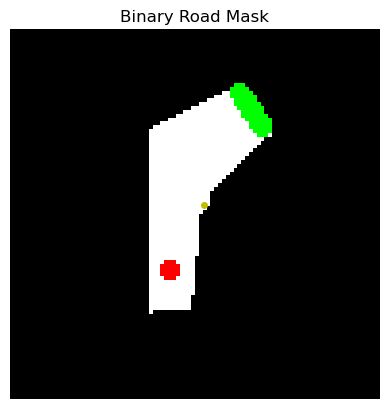

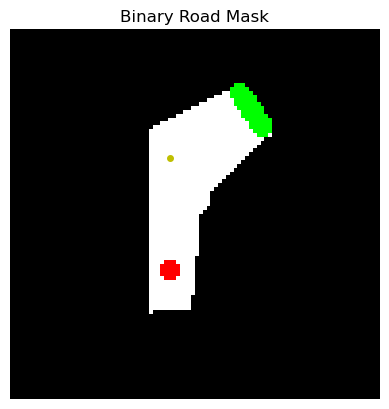

Reward: 200

215.1412365005745

-19.63028848171234

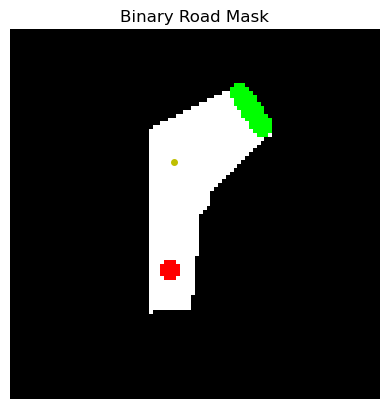

Reward: 199

-193.51262319599317

22.74292230606079

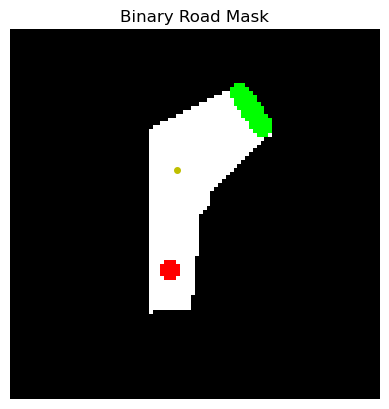

Reward: 198

-56.60049683078947

-23.603557348251343

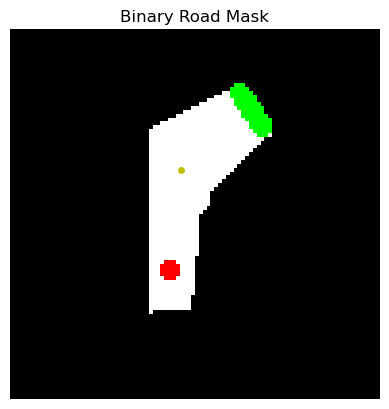

Reward: 197

72.76436702298442

-1.1782465875148773

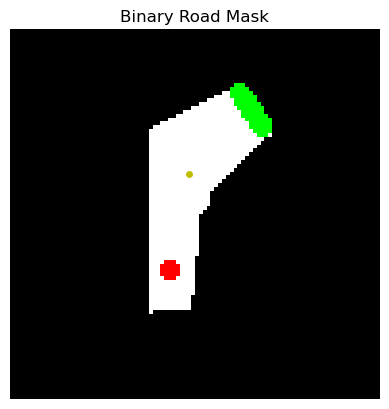

Reward: 196

-71.44215535829235

-13.67962896823883

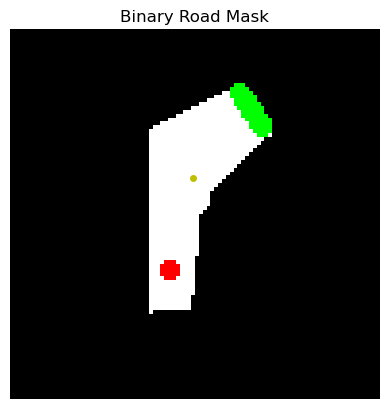

Reward: 195

-45.629171698718096

-13.535647988319397

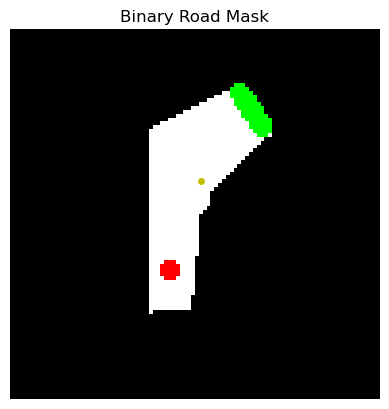

Reward: 194

36.30693033718691

11.064157783985138

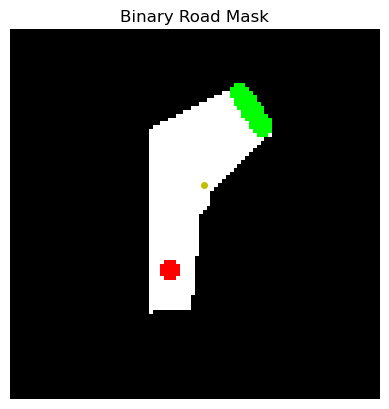

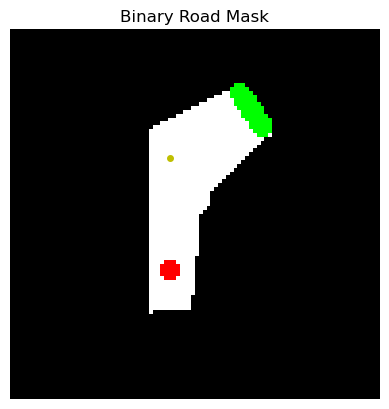

Reward: 200

-61.340272147816364

-24.45556640625

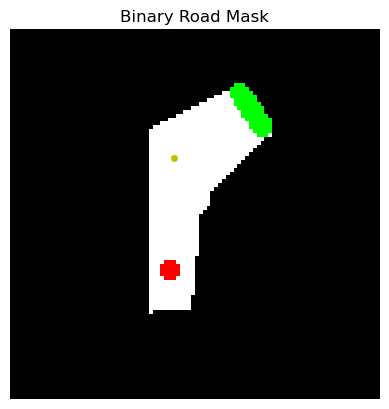

Reward: 199

218.48113954594425

-0.17838075757026672

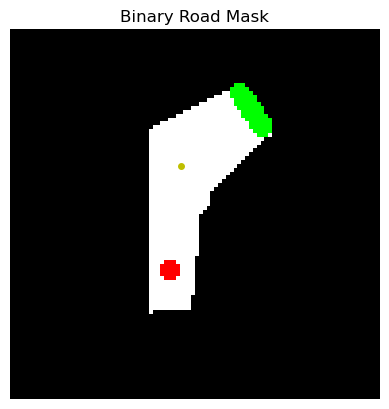

Reward: 198

-246.76819206178106

5.906821936368942

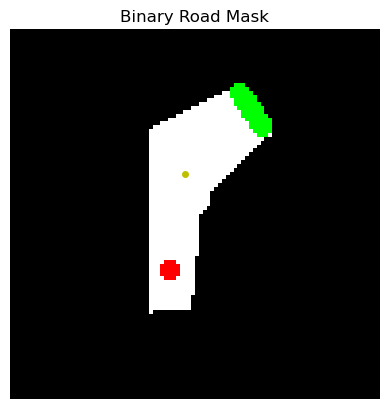

Reward: 197

125.5910037485892

-30.0

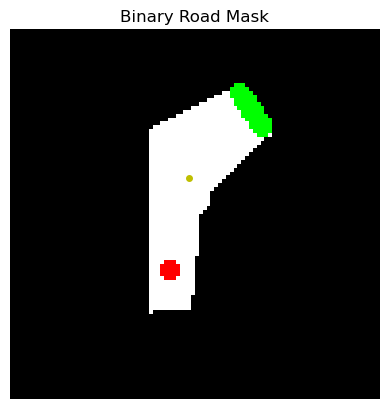

Reward: 196

220.2703026801364

-30.0

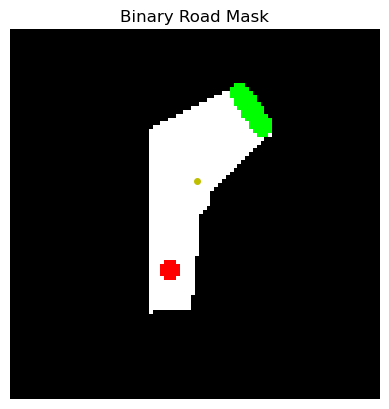

Reward: 195

158.92448685503103

-12.651447057723999

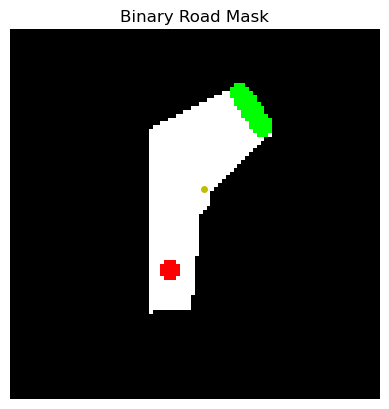

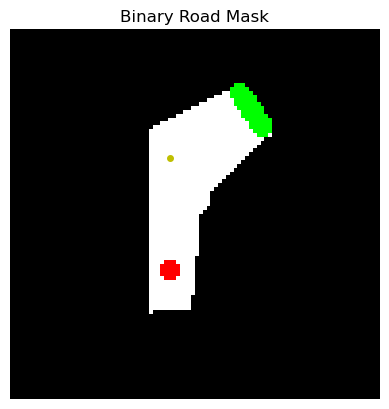

Reward: 200

213.71794907952312

-19.655638933181763

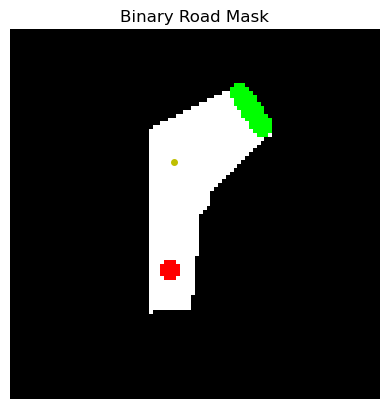

Reward: 199

229.50794394613044

-30.0

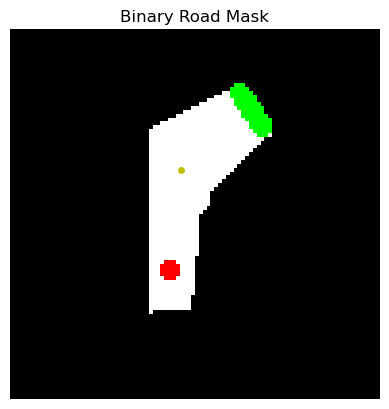

Reward: 198

248.73909360783574

-20.32152771949768

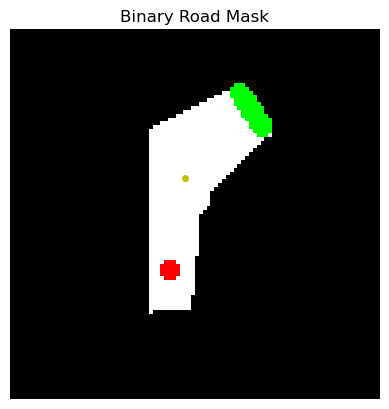

Reward: 197

-12.735579435775094

30.0

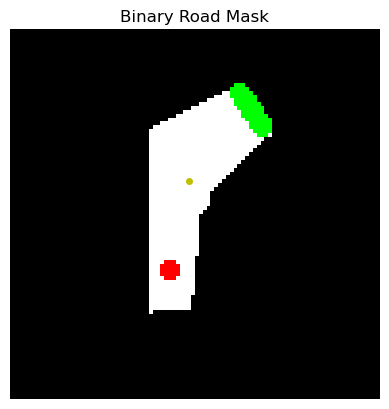

Reward: 196

-35.9379424749776

27.174906134605408

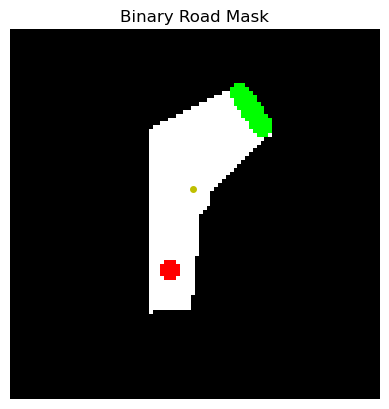

Reward: 195

46.646959310176044

7.836460769176483

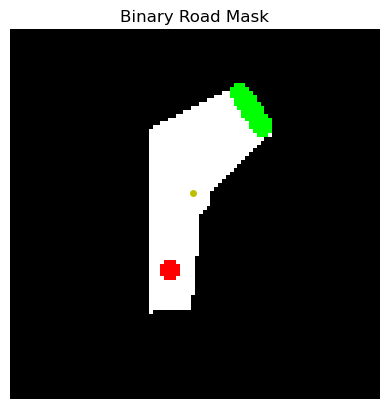

Reward: 194

10.239902919943233

12.580685913562775

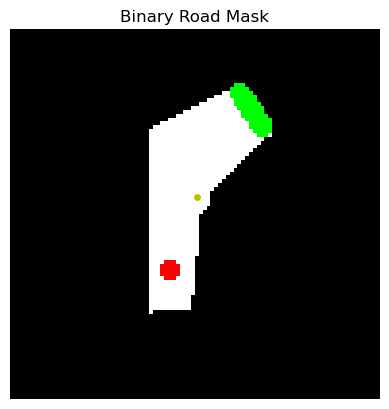

Reward: 193

91.13906301071121

-30.0

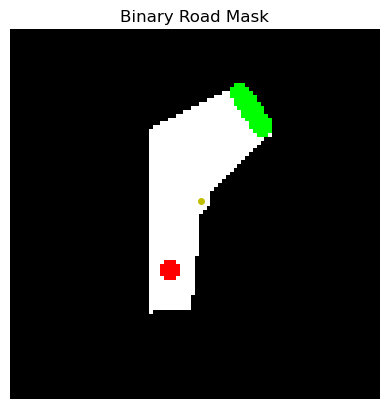

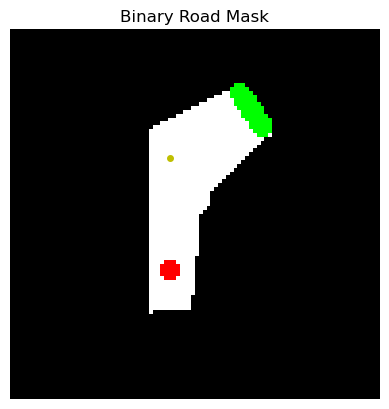

Reward: 200

11.903165323576502

19.52191472053528

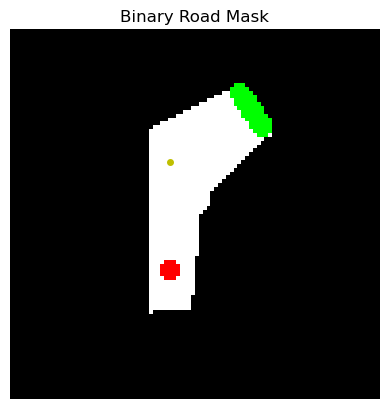

Reward: 199

-80.92892509099455

8.033929467201233

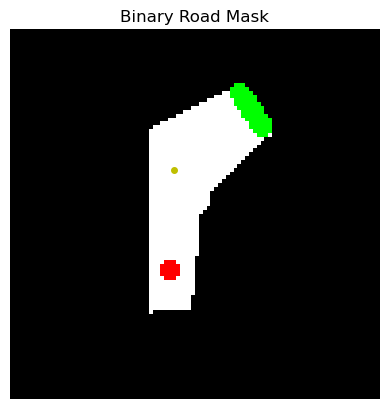

Reward: 198

-52.88247975480118

-29.308213591575623

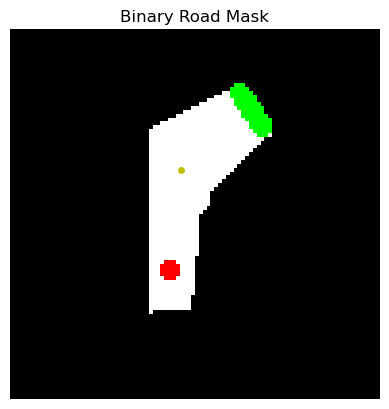

Reward: 197

-29.59433721105171

4.600657671689987

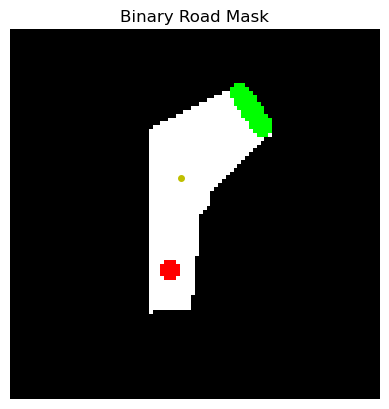

Reward: 196

-119.99754664257442

30.0

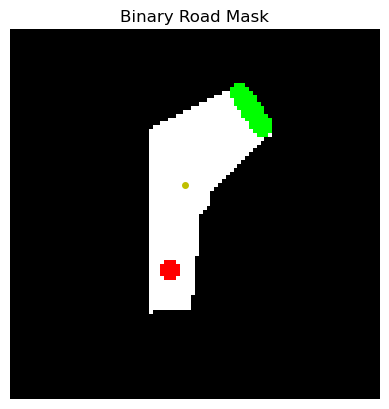

Reward: 195

11.060677799114245

-14.256314635276794

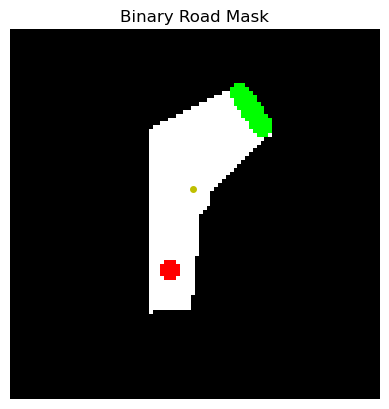

Reward: 194

49.29431336901854

30.0

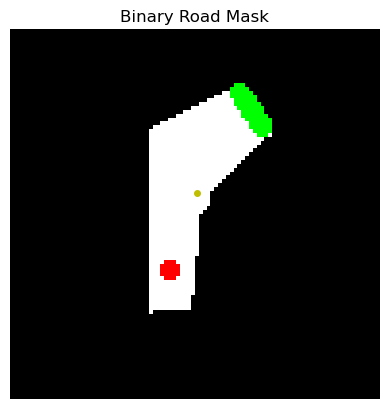

Reward: 193

59.08163861360052

17.069363594055176

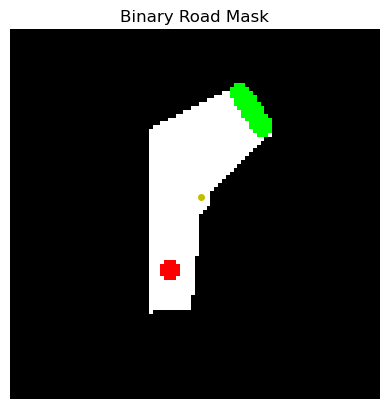

Reward: 192

-79.2383876858822

30.0

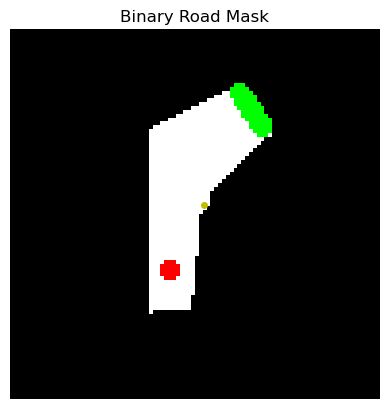

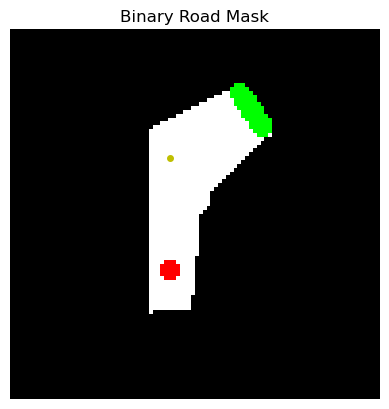

Reward: 200

77.16315426296467

14.378167390823364

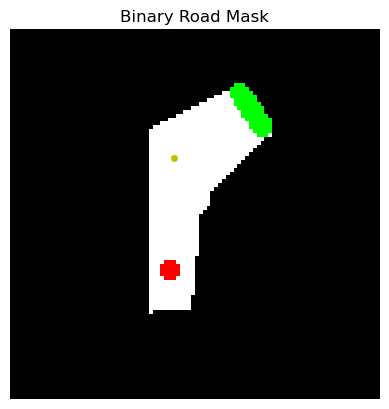

Reward: 199

-234.15860580458653

2.931431159377098

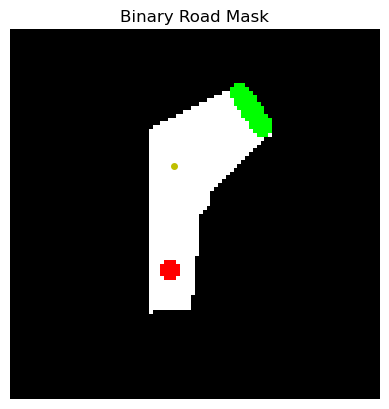

Reward: 198

235.98972050013126

-2.9836908727884293

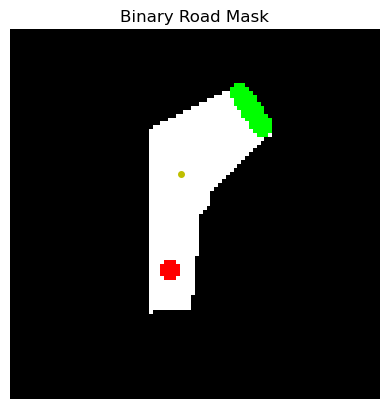

Reward: 197

65.61542934855964

-30.0

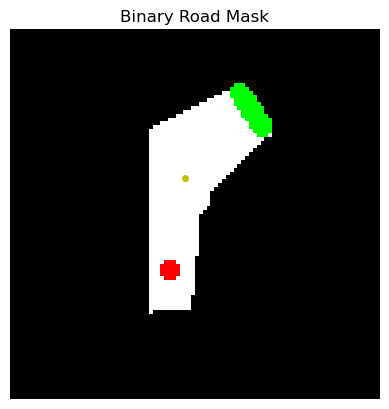

Reward: 196

50.98317031960718

19.45624351501465

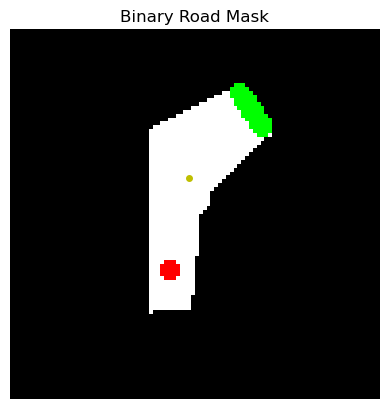

Reward: 195

-114.82557500772623

18.627975583076477

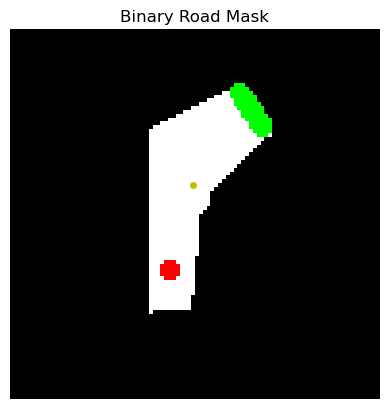

Reward: 194

125.40751873228535

-30.0

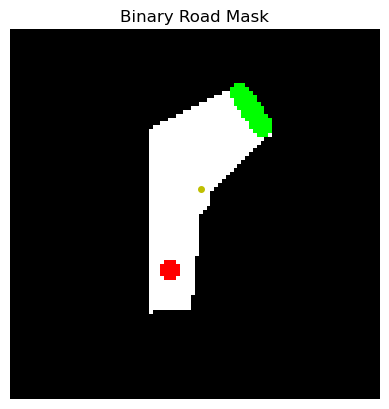

Reward: 193

209.68846953010905

-30.0

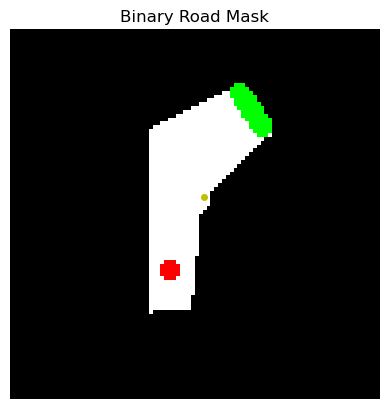

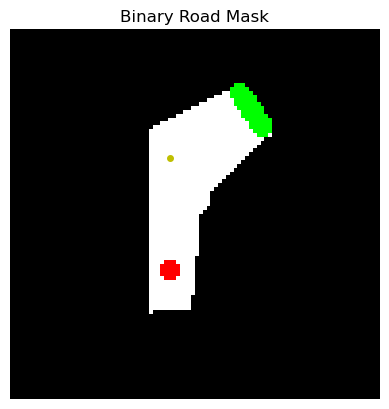

Reward: 200

-92.5652743869861

5.132330507040024

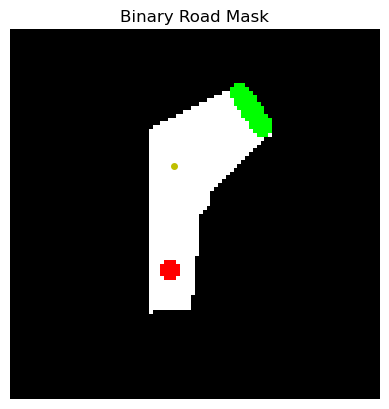

Reward: 199

115.26799584155279

-27.303455471992493

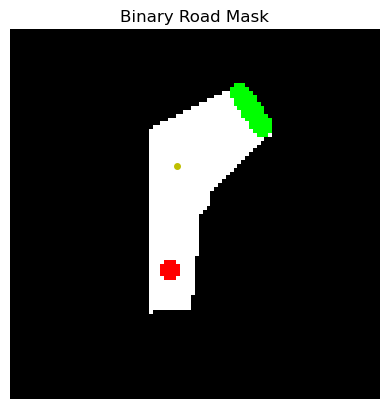

Reward: 198

267.2884534744742

-12.572447061538696

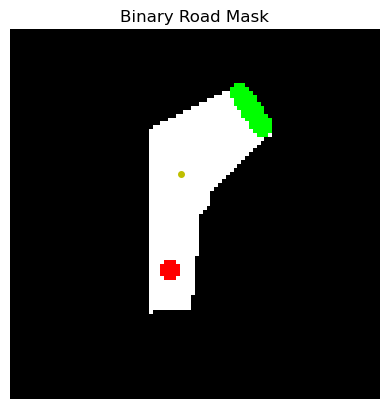

Reward: 197

148.98026006037068

-9.577855467796326

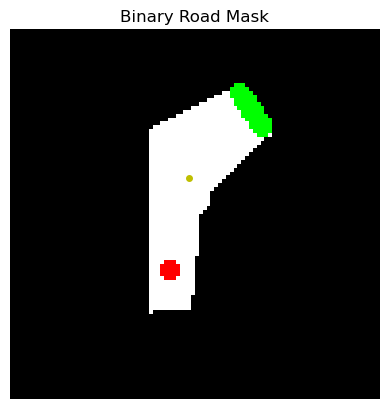

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.67     |
|    ep_rew_mean     | 1.5e+03  |
| time/              |          |
|    fps             | 26       |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 50       |
---------------------------------


Reward: 196

31.573205258314715

30.0

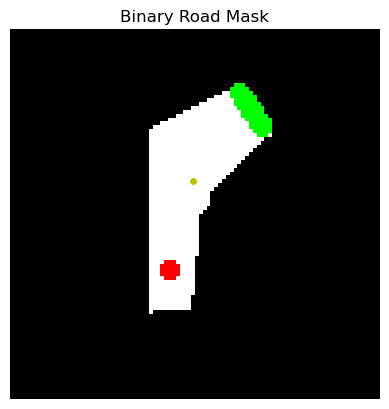

Reward: 195

-23.68996258910221

14.495981633663177

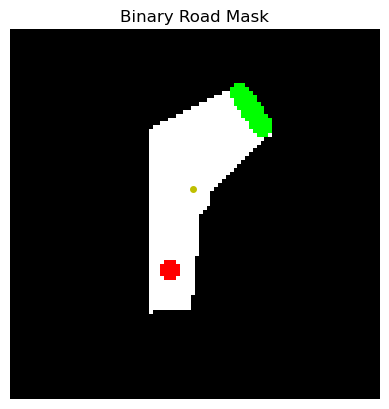

Reward: 194

-156.49189176946265

29.74186420440674

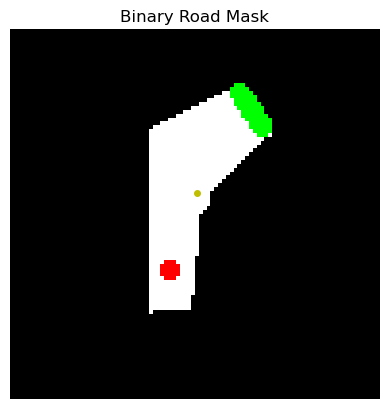

Reward: 193

-237.87643530526333

10.32691776752472

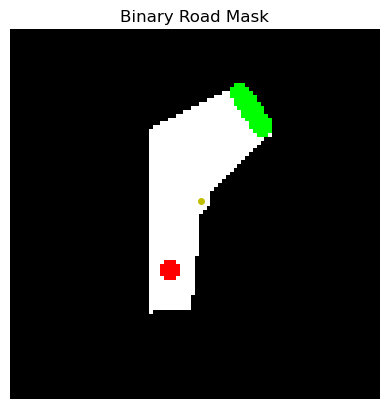

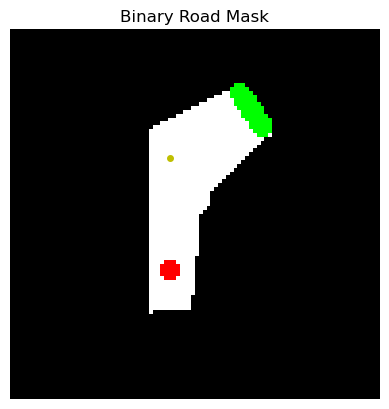

Reward: 200

-19.000601640381134

-30.0

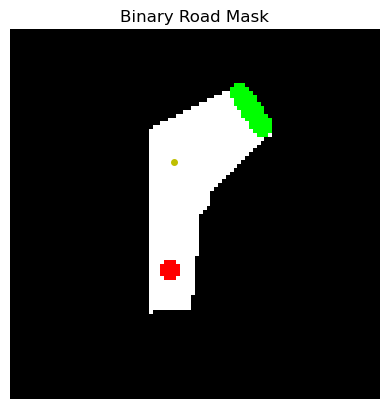

Reward: 199

-233.02120916553667

30.0

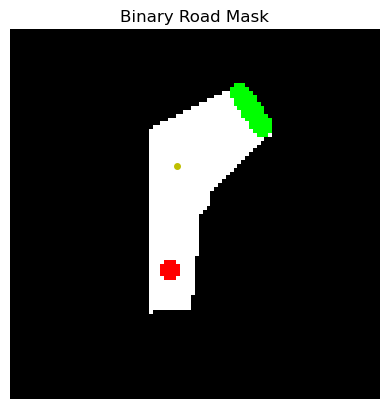

Reward: 198

-255.4987491827747

30.0

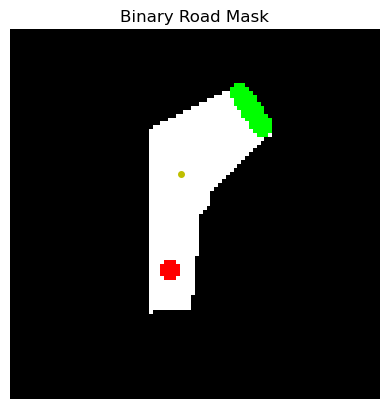

Reward: 197

-14.633072082233028

-30.0

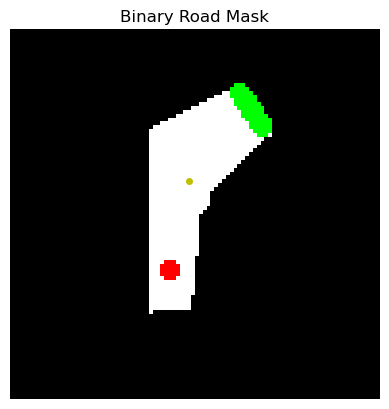

Reward: 196

189.7584672640786

-9.687774181365967

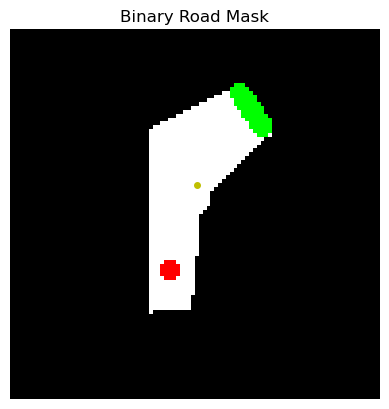

Reward: 195

171.99533212211145

-0.7610535621643066

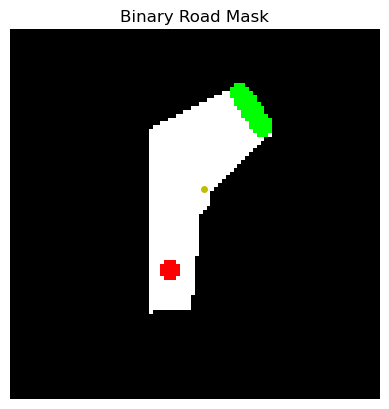

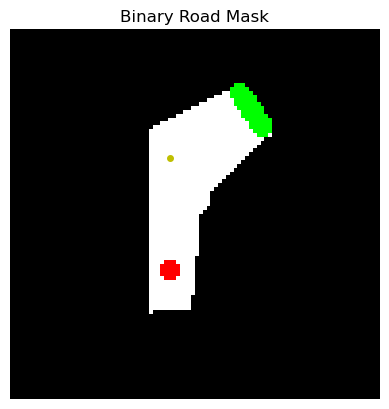

Reward: 200

33.473452606648124

13.61570656299591

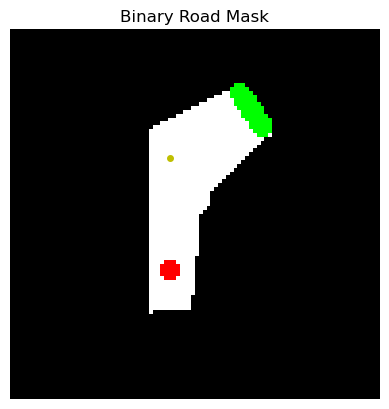

Reward: 199

-243.9383916753083

15.034579038619995

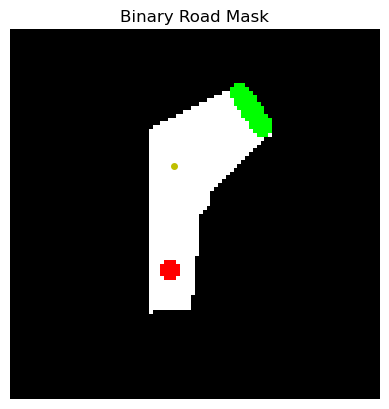

Reward: 198

-72.2733772420327

-30.0

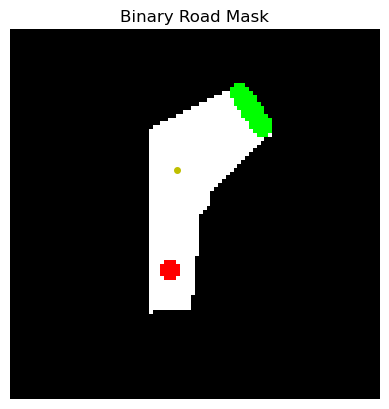

Reward: 197

-269.42632944953624

0.9560121595859528

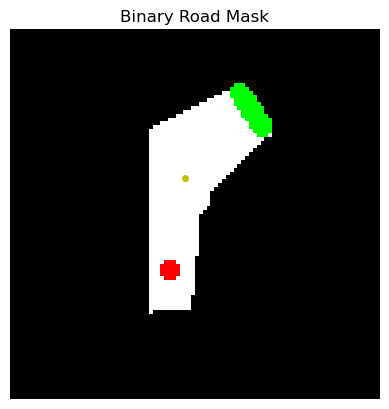

Reward: 196

-3.740758905151992

-28.448683619499207

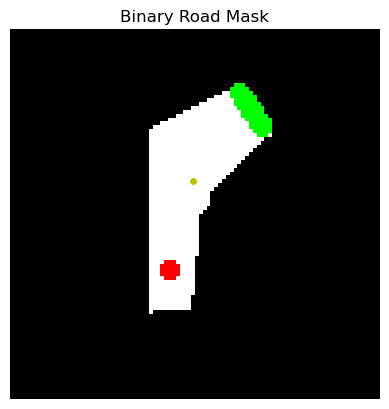

Reward: 195

-91.7631407914073

4.639205038547516

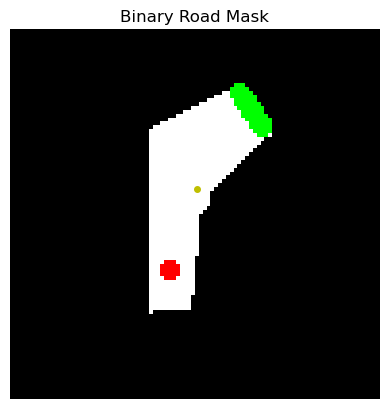

Reward: 194

-82.00760917475087

30.0

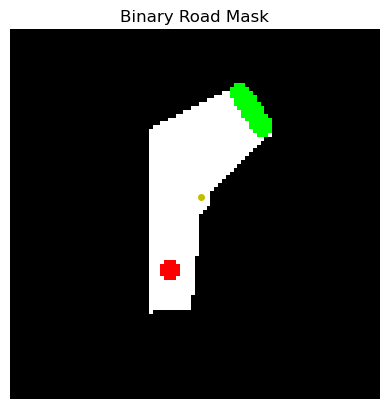

Reward: 193

-243.12573674582927

30.0

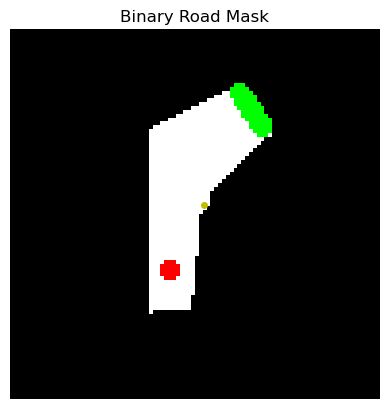

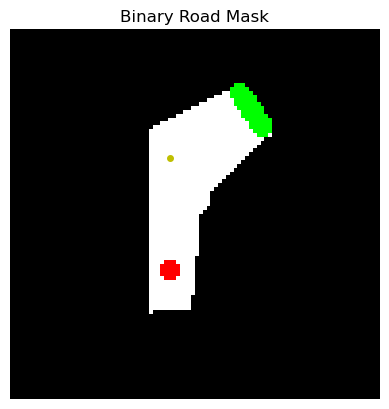

Reward: 200

-7.996309809643748

25.458780527114868

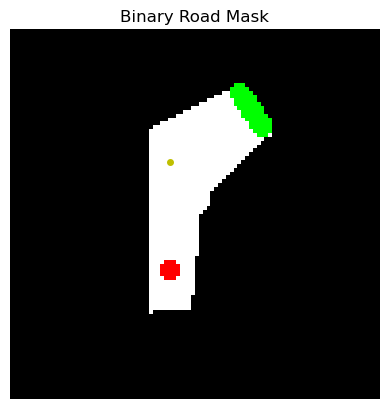

Reward: 199

-97.21639384421778

15.082764029502869

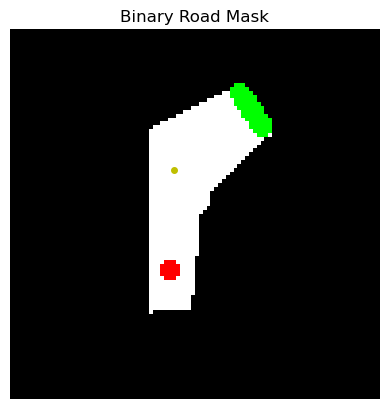

Reward: 198

195.16963154218786

-8.691734969615936

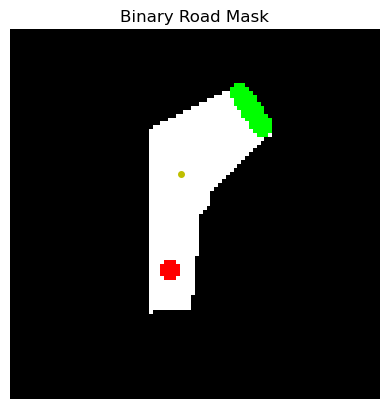

Reward: 197

-145.97873106196772

5.844532549381256

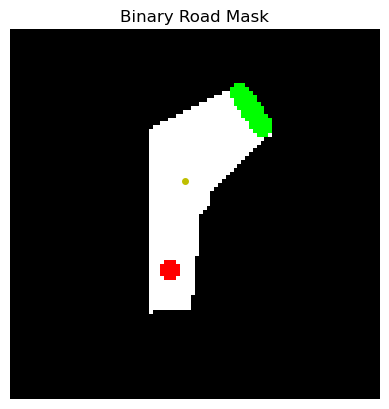

Reward: 196

-74.60907888078907

-2.3367201536893845

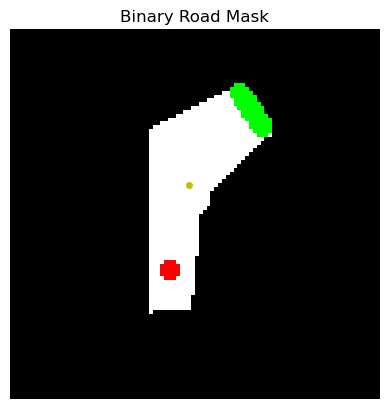

Reward: 195

55.4907435220577

21.529219150543213

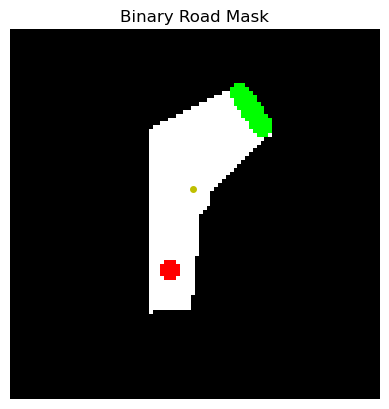

Reward: 194

23.295269968408334

-7.318696975708008

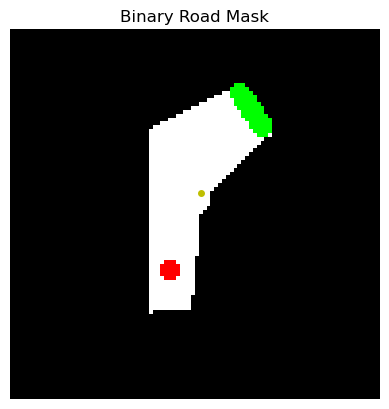

Reward: 193

30.353724845303134

30.0

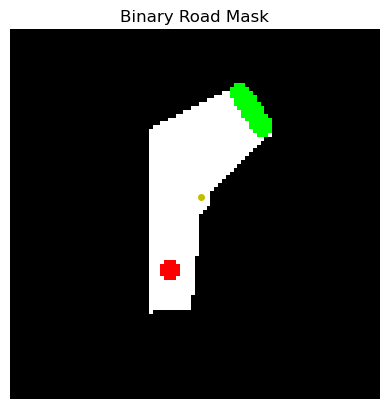

Reward: 192

-238.58404442209337

11.964951753616333

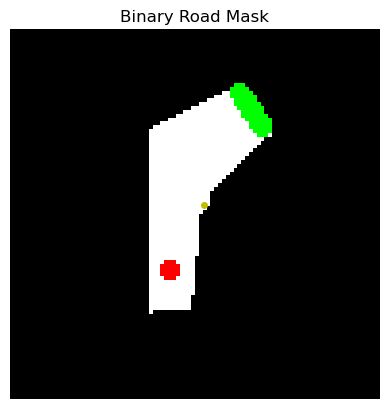

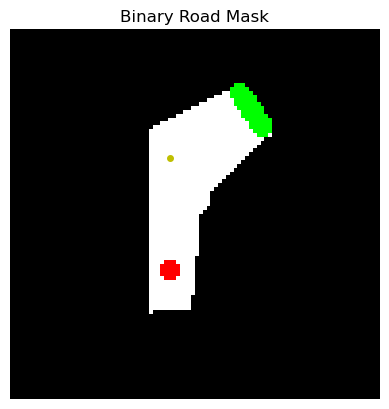

Reward: 200

-18.988796556258265

-30.0

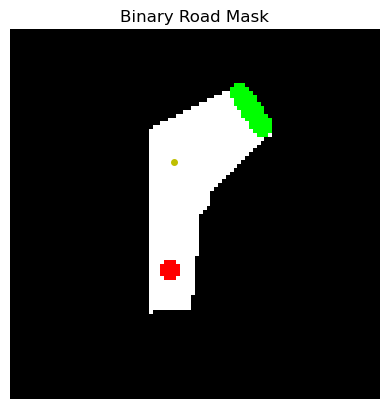

Reward: 199

62.72233835992441

3.7341029942035675

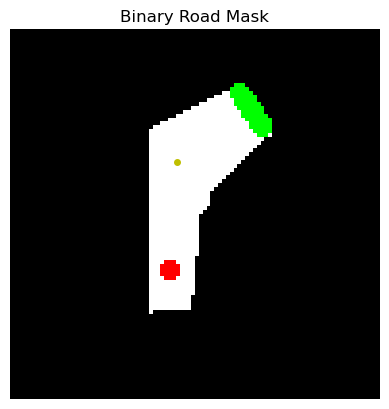

Reward: 198

-29.69190075857007

-2.9087217897176743

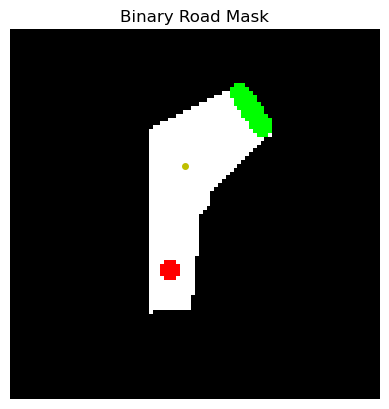

Reward: 197

-269.1962832608282

27.49355435371399

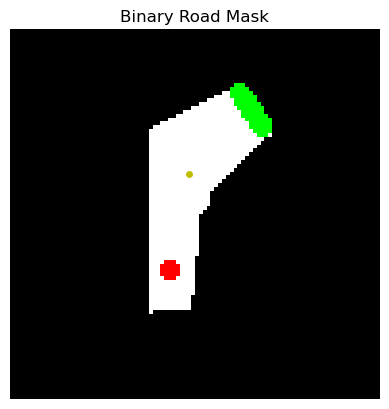

Reward: 196

54.71500198510892

-8.808953762054443

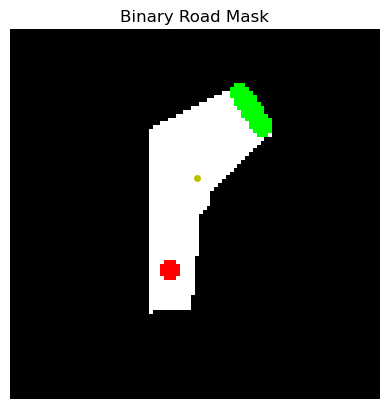

Reward: 195

-13.226210501367007

29.235581159591675

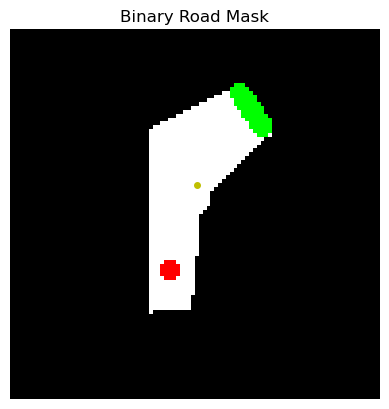

Reward: 194

-89.76964199160005

-9.690136313438416

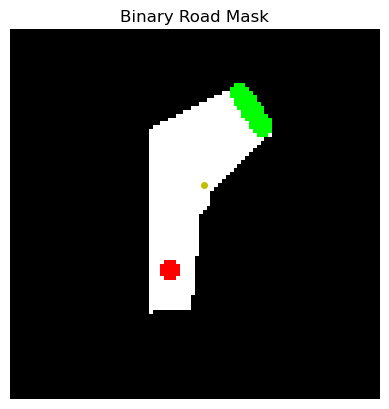

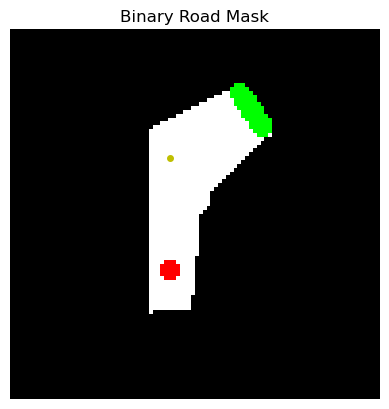

Reward: 200

-107.76533862168303

30.0

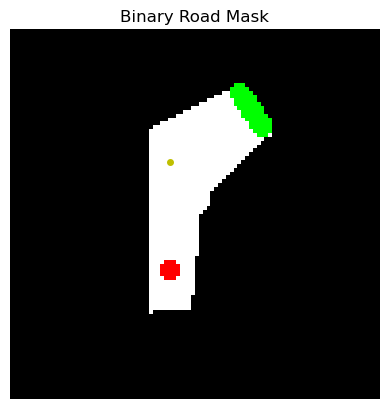

Reward: 199

-102.14243336408504

7.951667010784149

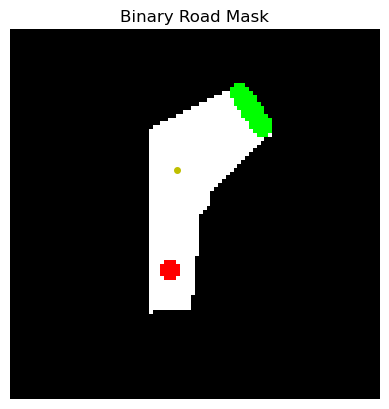

Reward: 198

43.291818003915864

30.0

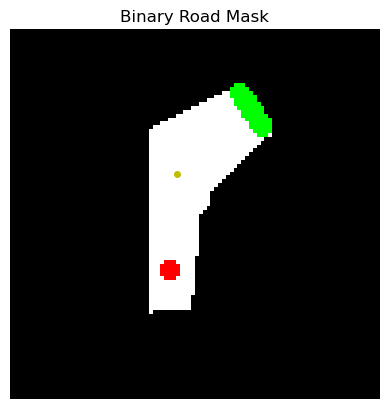

Reward: 197

184.8053860351991

-30.0

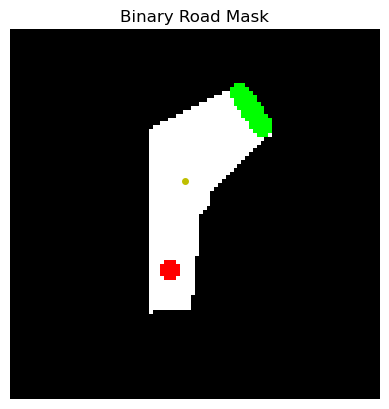

Reward: 196

253.57295548961903

-25.800474286079407

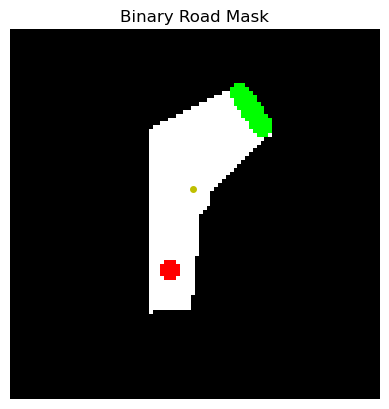

Reward: 195

40.83413049805722

-29.1656094789505

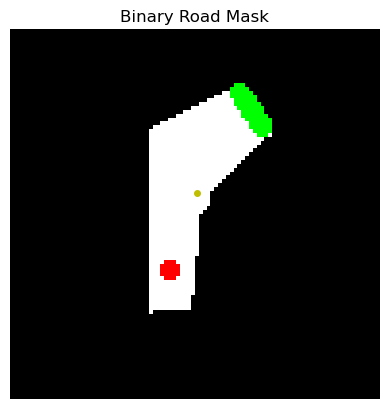

Reward: 194

59.60390217817702

-10.877934694290161

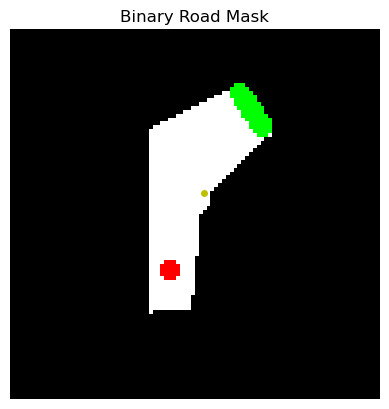

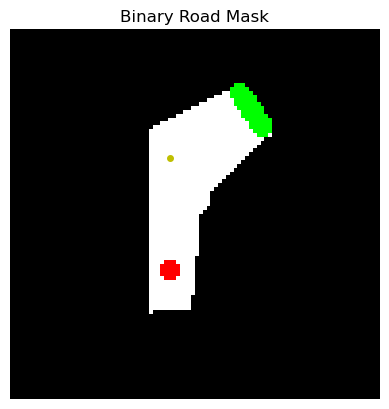

Reward: 200

-213.63545554044555

3.019152581691742

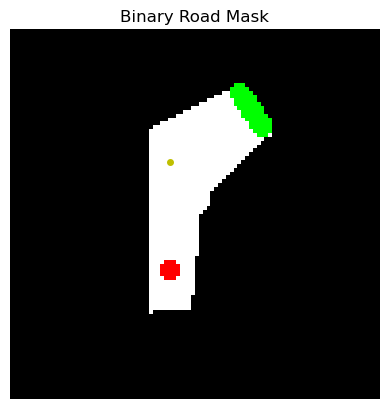

Reward: 199

-260.05930465746474

16.817834973335266

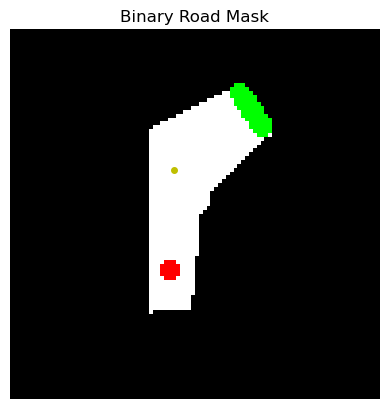

Reward: 198

256.13615823882765

-1.864074021577835

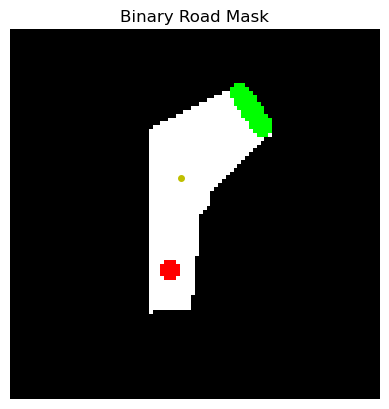

Reward: 197

-98.1763862688784

14.827323853969574

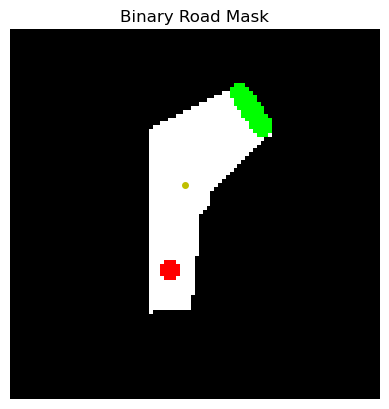

Reward: 196

-88.49577424402297

4.884079098701477

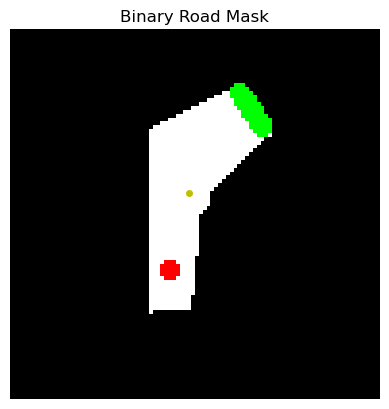

Reward: 195

-134.1277991279532

6.973408609628677

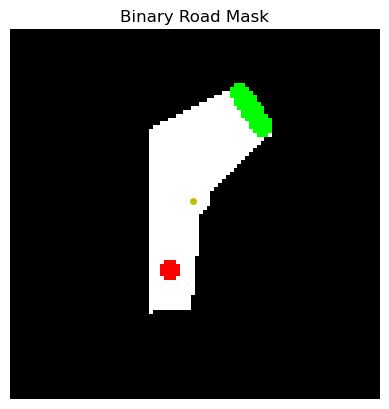

Reward: 194

-54.49361797230756

-26.40294849872589

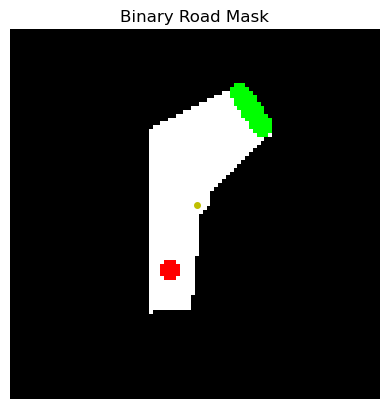

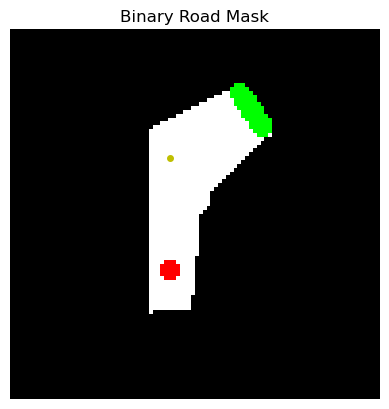

Reward: 200

-109.24157214323778

4.841169565916061

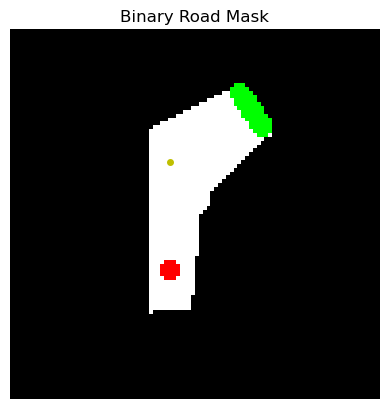

Reward: 199

-60.287355556342135

-7.408262193202972

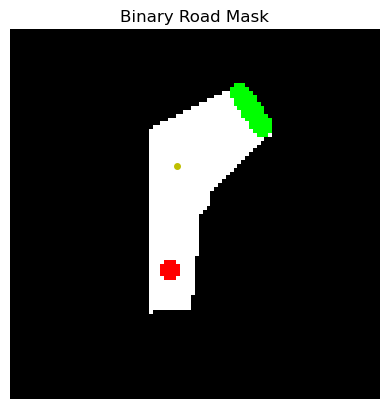

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.54         |
|    ep_rew_mean          | 1.48e+03     |
| time/                   |              |
|    fps                  | 25           |
|    iterations           | 2            |
|    time_elapsed         | 3            |
|    total_timesteps      | 100          |
| train/                  |              |
|    approx_kl            | 0.0017309701 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84        |
|    explained_variance   | 5.52e-05     |
|    learning_rate        | 0.0003       |
|    loss                 | 3.24e+05     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00428     |
|    std                  | 0.998        |
|    value_loss           | 6.49e+05     |
------------------------------------------


Reward: 198

-51.973748185999085

-5.951651483774185

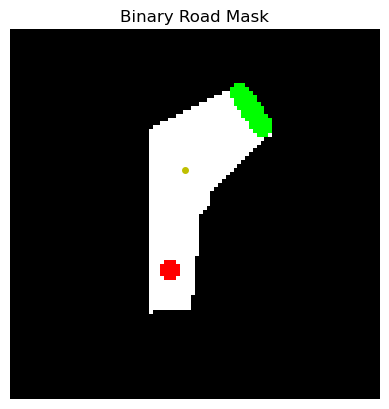

Reward: 197

12.843583413032263

-25.70032775402069

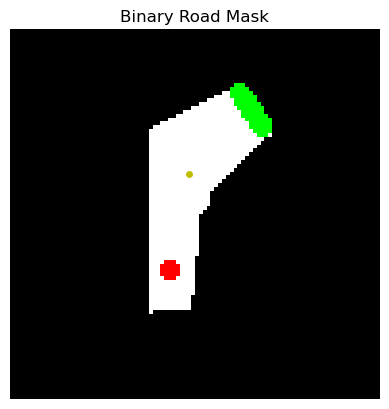

Reward: 196

-42.57139432067987

-16.086822152137756

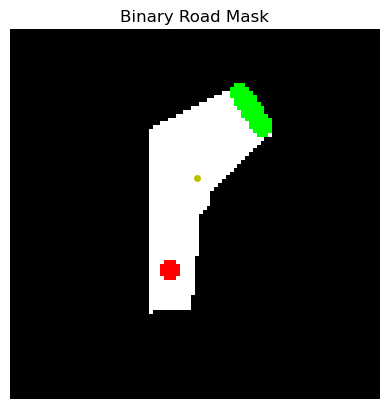

Reward: 195

-143.528149524507

30.0

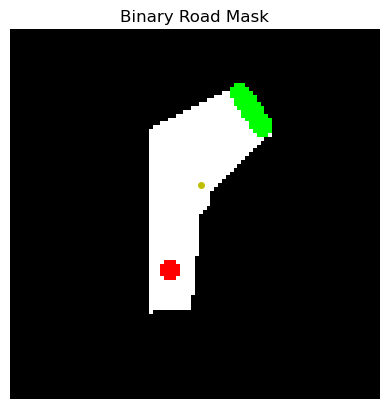

Reward: 194

-18.860512552137124

13.752095103263855

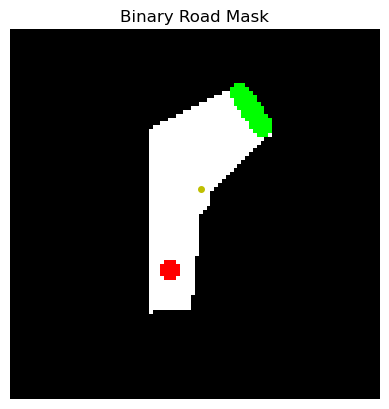

Reward: 193

70.25558297650218

28.871052861213684

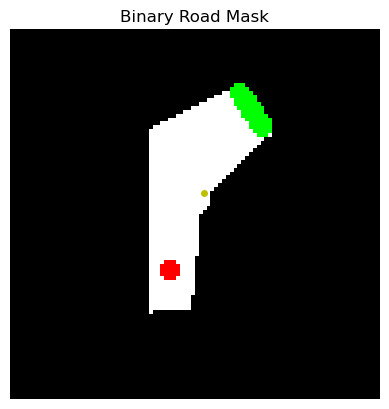

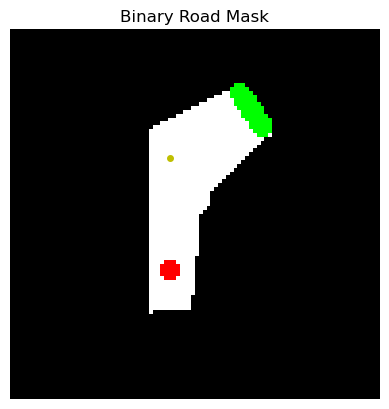

Reward: 200

-107.77294939571665

30.0

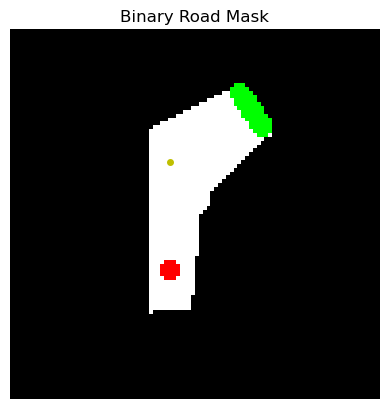

Reward: 199

-166.49052031098705

13.119862675666809

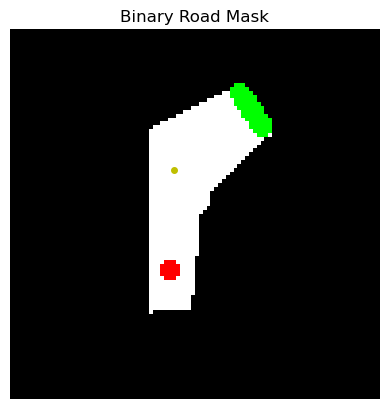

Reward: 198

256.87948717842187

-1.172105222940445

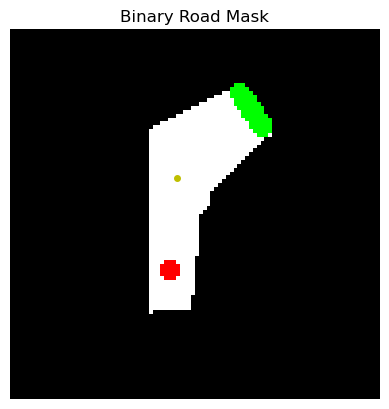

Reward: 197

-266.30900694895007

30.0

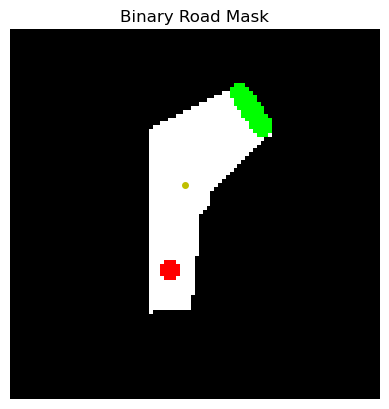

Reward: 196

-2.7605510538751616

30.0

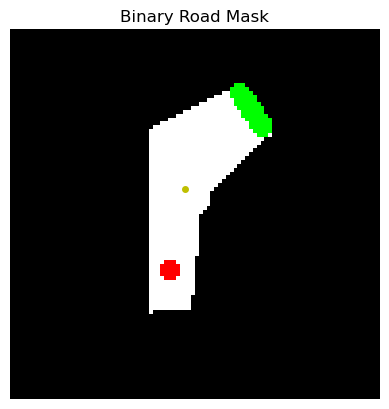

Reward: 195

66.19900244490984

-30.0

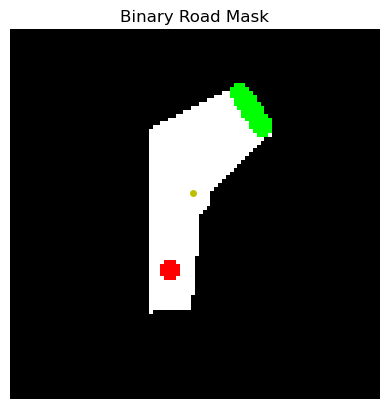

Reward: 194

211.5832345382697

-2.1744194626808167

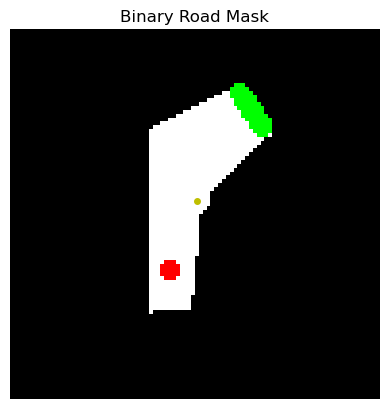

Reward: 193

90.56785150227753

-5.157602280378342

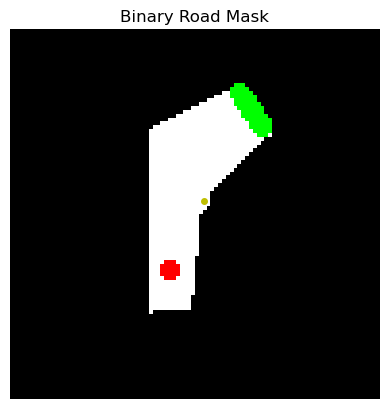

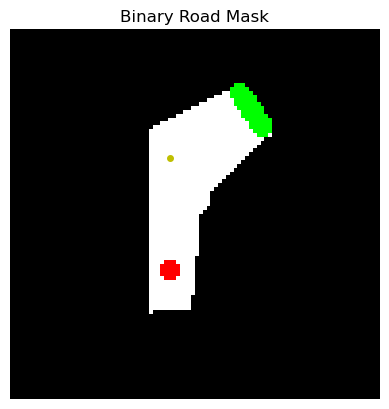

Reward: 200

-107.7515756342361

30.0

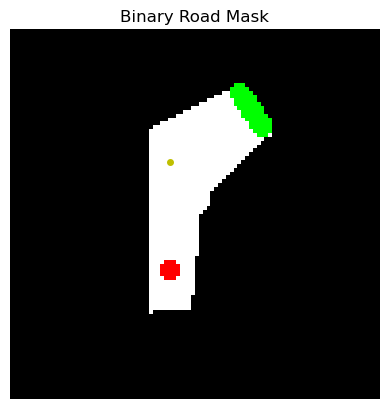

Reward: 199

-151.48316481616231

13.359931111335754

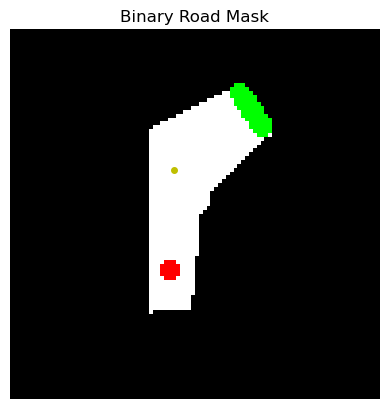

Reward: 198

-65.85216458106076

27.170857787132263

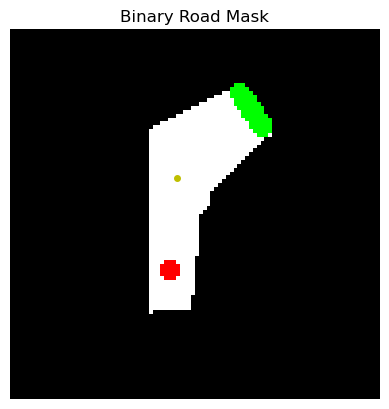

Reward: 197

-37.418029258015395

30.0

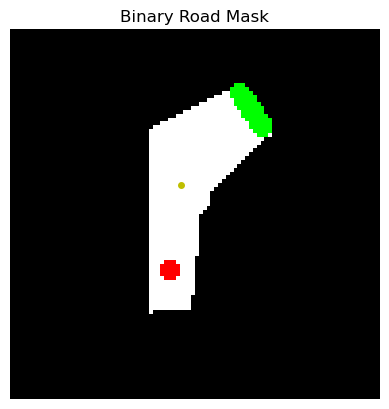

Reward: 196

-47.18649614854726

7.6788389682769775

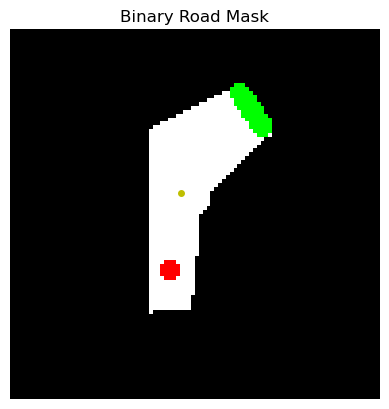

Reward: 195

185.16745122246095

-27.479960918426514

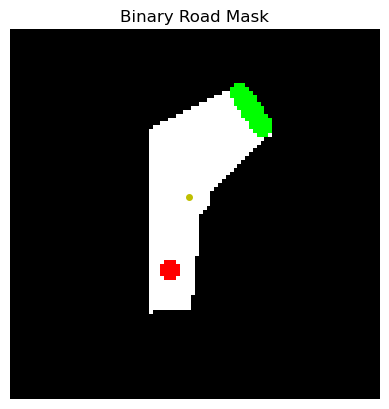

Reward: 194

-55.121320785273596

30.0

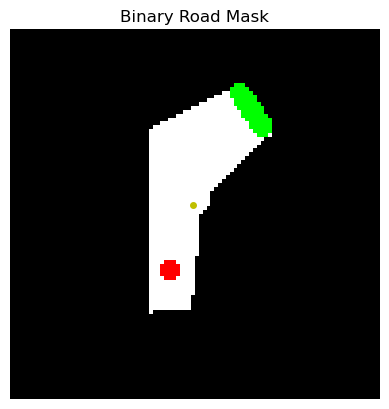

Reward: 193

13.875879852460343

-22.534738183021545

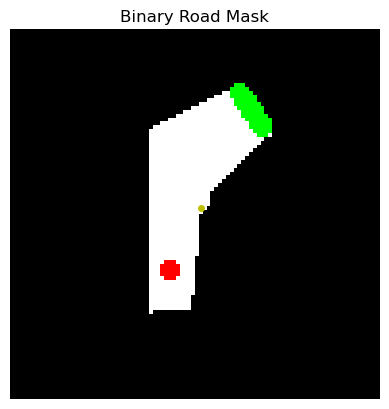

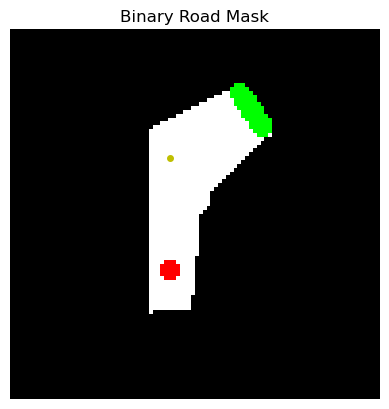

Reward: 200

-107.74677078493926

30.0

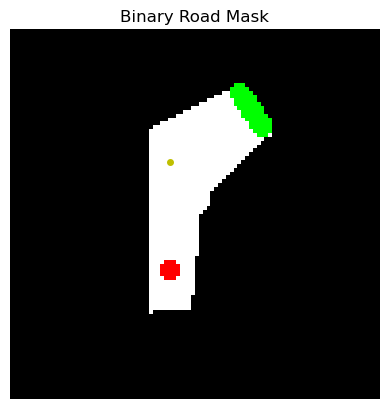

Reward: 199

-182.04779498296665

6.538487523794174

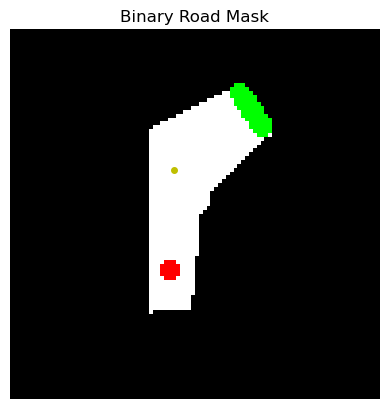

Reward: 198

233.80452065968356

-30.0

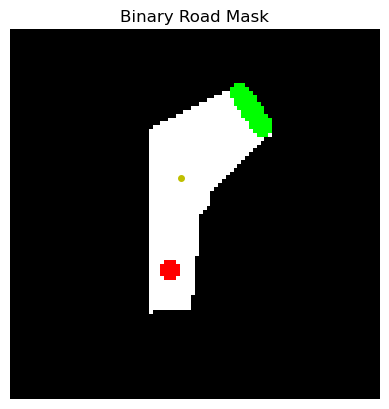

Reward: 197

-55.478018859744026

12.77144730091095

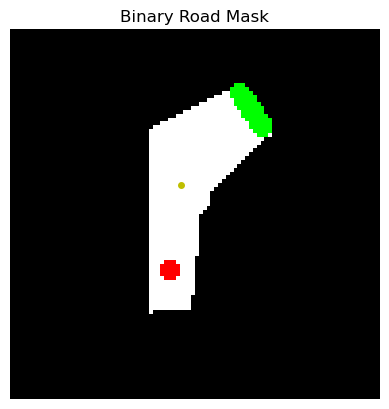

Reward: 196

-74.28940944816827

-30.0

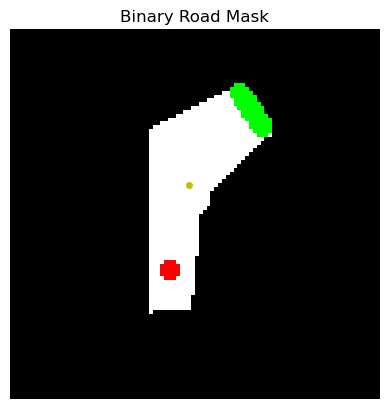

Reward: 195

-224.61746795108849

10.037257075309753

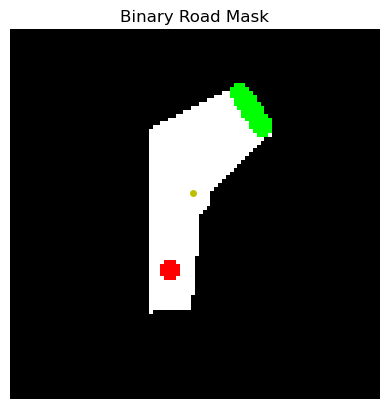

Reward: 194

17.24162607897364

-3.7762950360774994

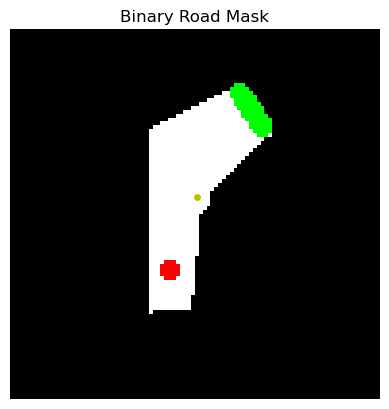

Reward: 193

1.6184024862987485

16.702687740325928

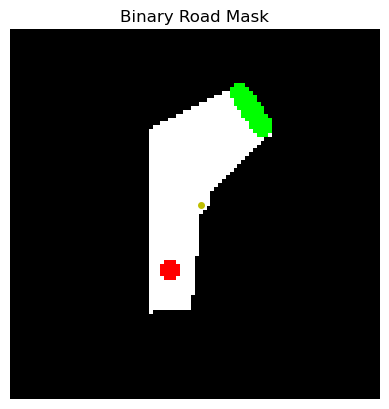

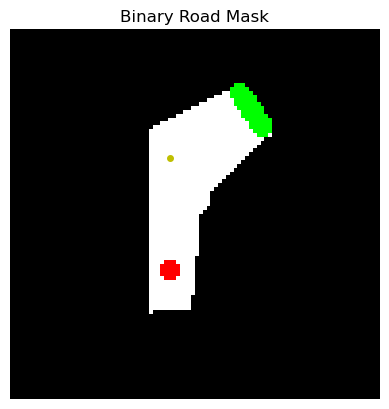

Reward: 200

78.3733841206456

8.115679621696472

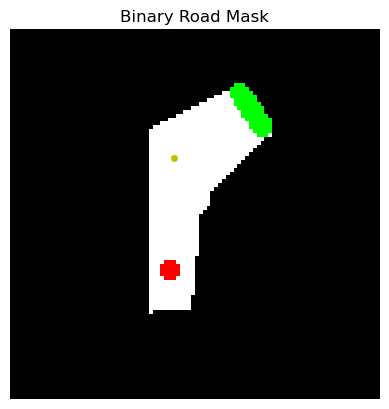

Reward: 199

171.58512081287333

-21.33000612258911

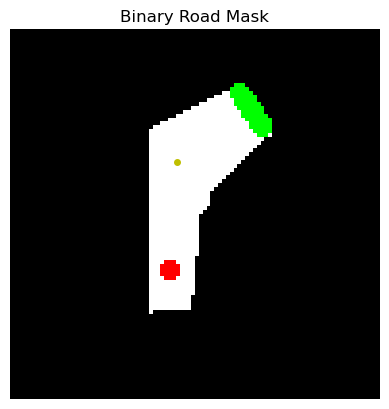

Reward: 198

119.13741329102105

-8.642977774143219

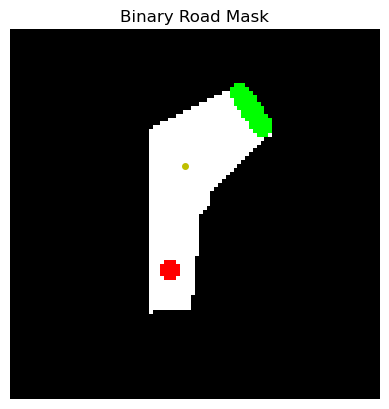

Reward: 197

266.5742902159785

-16.454479694366455

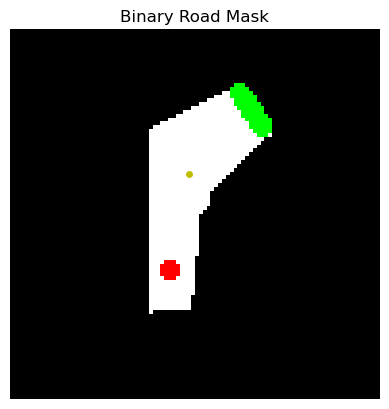

Reward: 196

-70.78517089122498

30.0

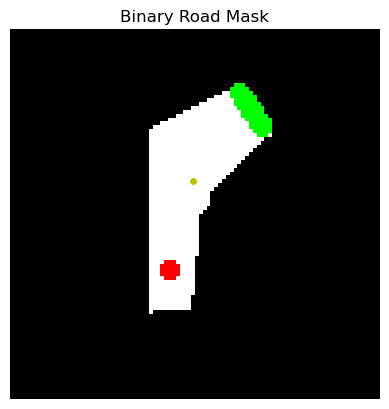

Reward: 195

-27.31867657651648

16.259717345237732

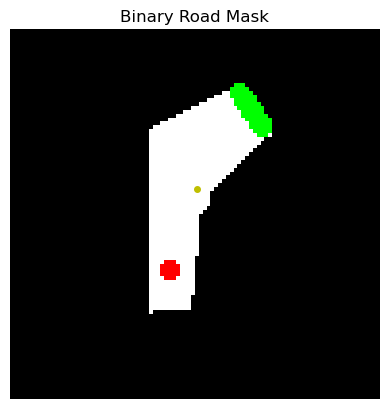

Reward: 194

39.29450827633599

5.371964871883392

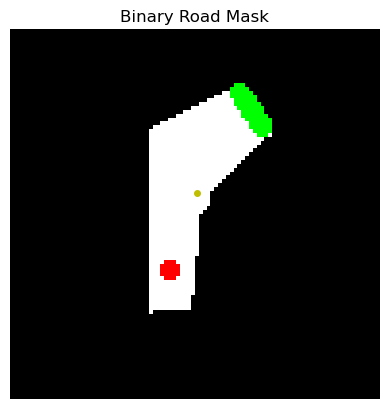

Reward: 193

-192.76881656701454

16.389724016189575

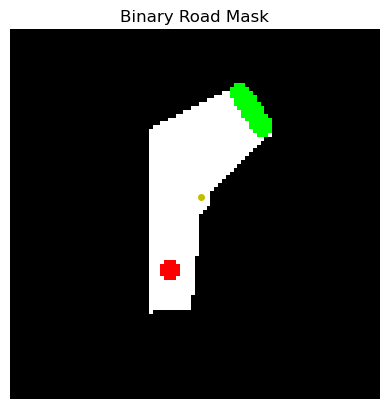

Reward: 192

-109.20653798382367

30.0

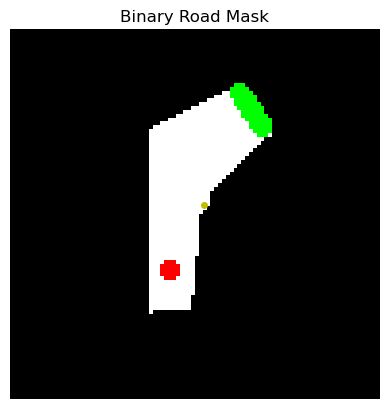

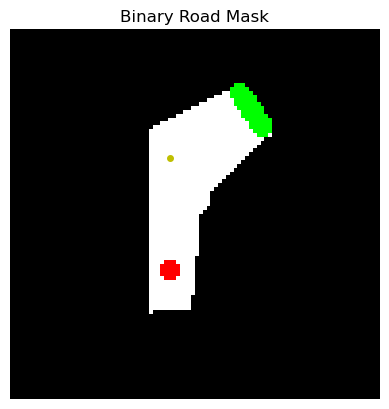

Reward: 200

-46.39035421621978

-24.195147156715393

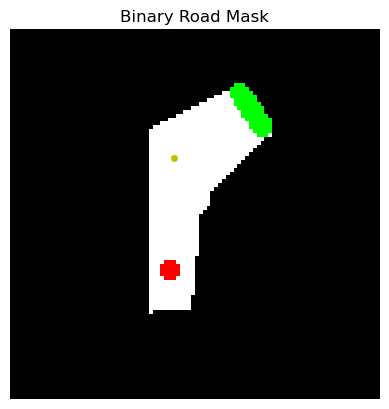

Reward: 199

42.68526537964135

18.219441175460815

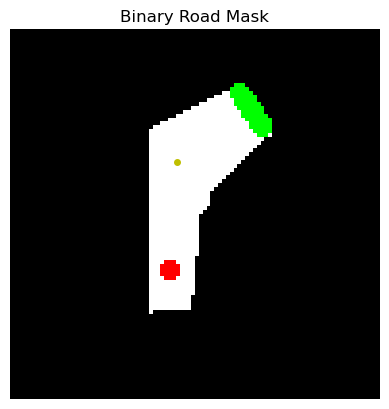

Reward: 198

61.24971057506107

30.0

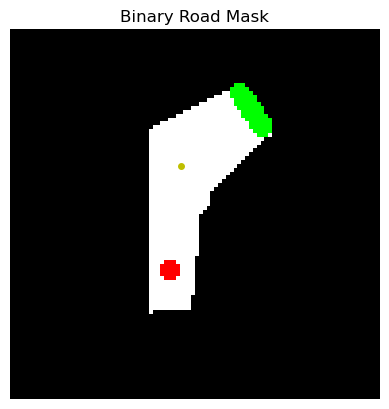

Reward: 197

44.914069274529936

30.0

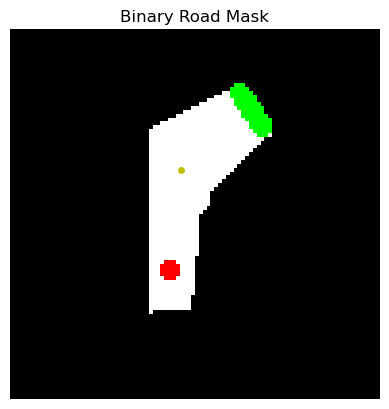

Reward: 196

-259.4006089937801

22.17358946800232

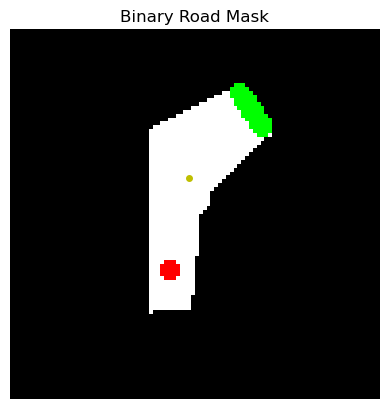

Reward: 195

189.6078624237345

-28.816648721694946

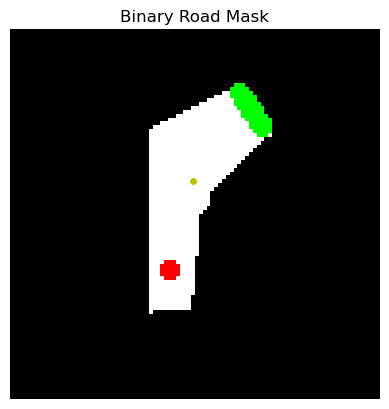

Reward: 194

-20.282632253201

19.88326907157898

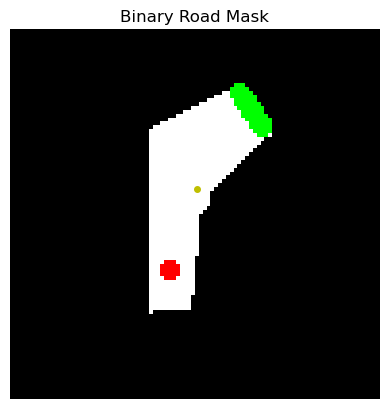

Reward: 193

-58.96575045726745

21.754034757614136

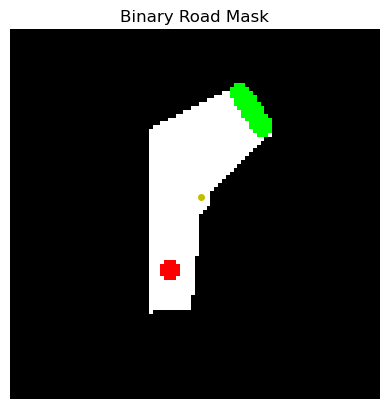

Reward: 192

-168.92035386001982

20.818437337875366

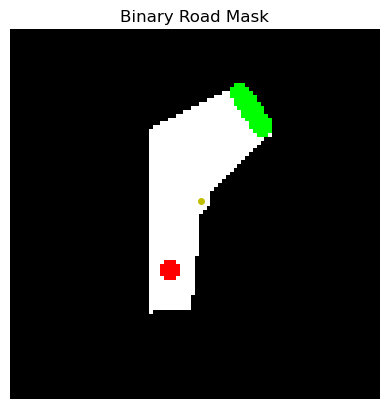

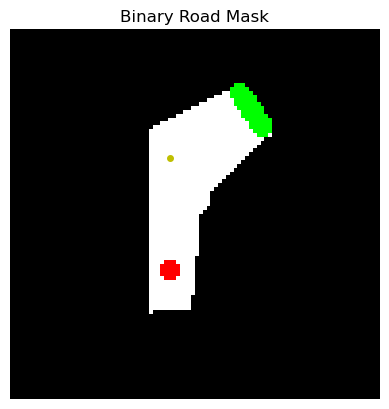

Reward: 200

6.888487664847474

13.15164864063263

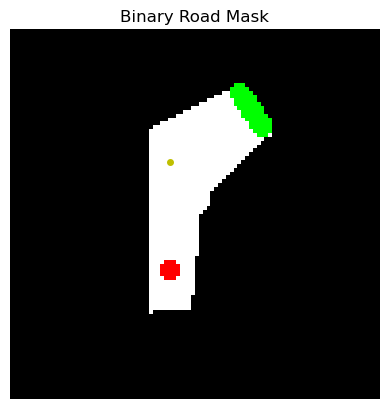

Reward: 199

-189.68565653865994

30.0

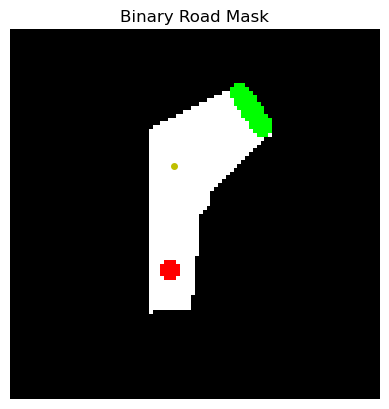

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 7.79          |
|    ep_rew_mean          | 1.52e+03      |
| time/                   |               |
|    fps                  | 24            |
|    iterations           | 3             |
|    time_elapsed         | 6             |
|    total_timesteps      | 150           |
| train/                  |               |
|    approx_kl            | 0.00063995837 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.83         |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 2.94e+05      |
|    n_updates            | 20            |
|    policy_gradient_loss | -0.000751     |
|    std                  | 0.997         |
|    value_loss           | 5.88e+05      |
-------------------------------------------


Reward: 198

-86.78844404331801

-2.8247306495904922

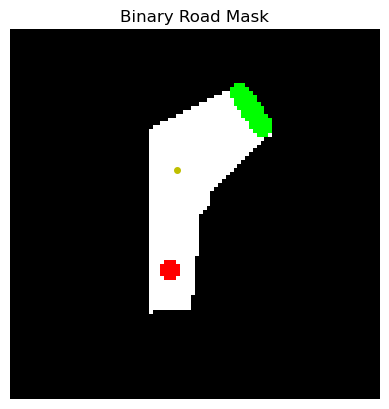

Reward: 197

233.95235144885055

-18.442715406417847

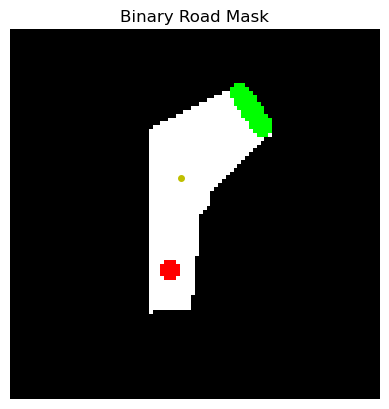

Reward: 196

-44.23411675832679

-17.31291174888611

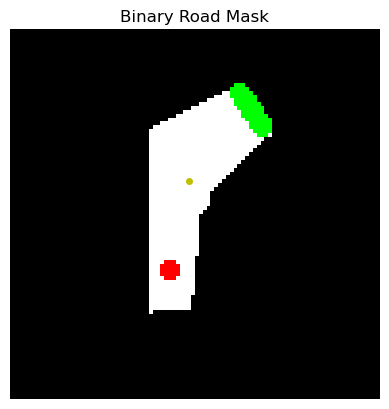

Reward: 195

10.006780205609346

21.776112914085388

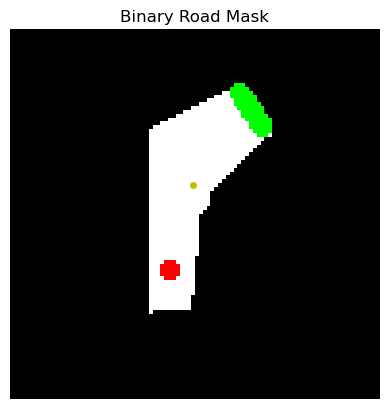

Reward: 194

77.78211537074549

-30.0

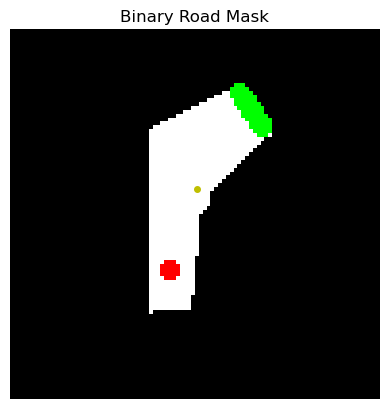

Reward: 193

53.78947705089095

13.62180233001709

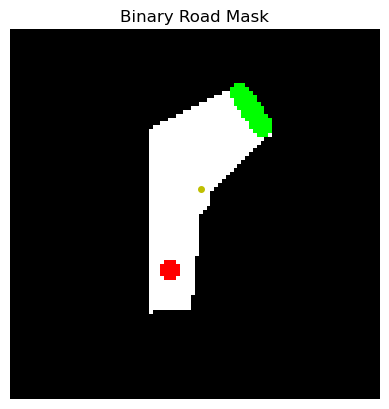

Reward: 192

-212.65403596271432

14.114075303077698

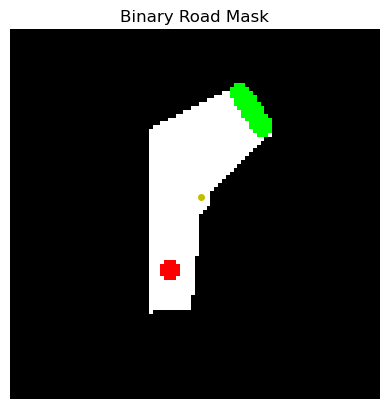

Reward: 191

31.210745588941478

-15.496351718902588

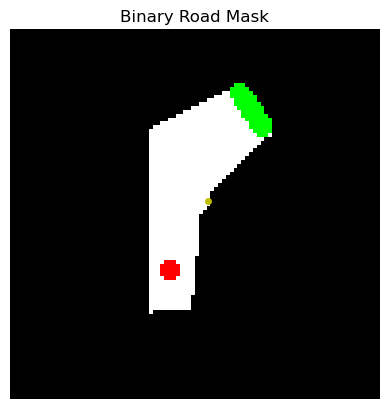

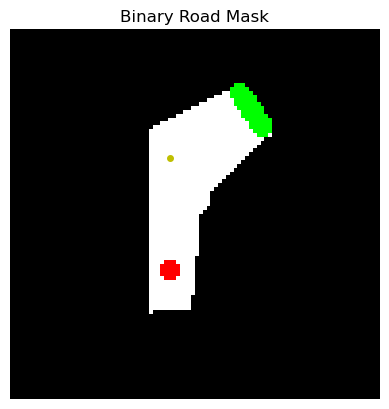

Reward: 200

59.60913088536594

7.788170278072357

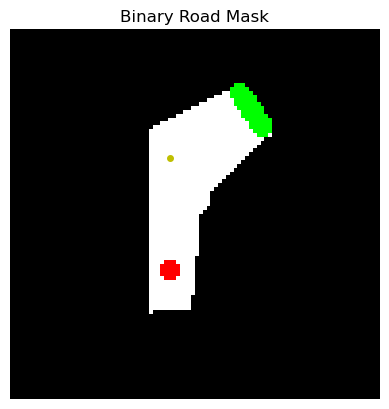

Reward: 199

-49.015306787955524

30.0

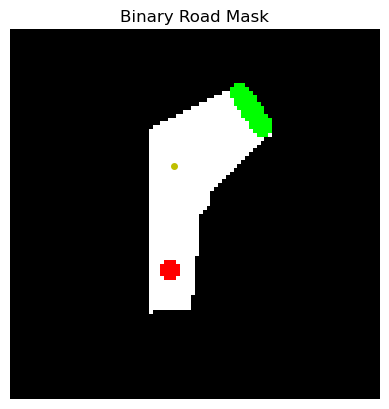

Reward: 198

-152.80082863312103

30.0

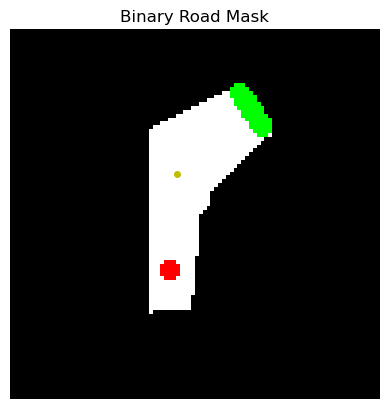

Reward: 197

20.73184902627827

30.0

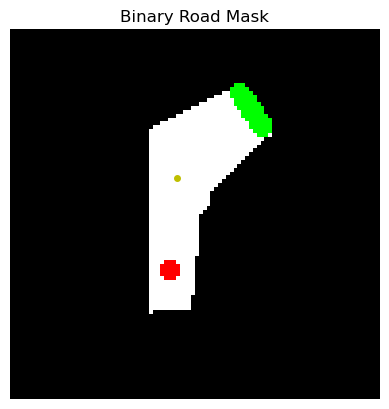

Reward: 196

80.38637759006689

-2.9793012142181396

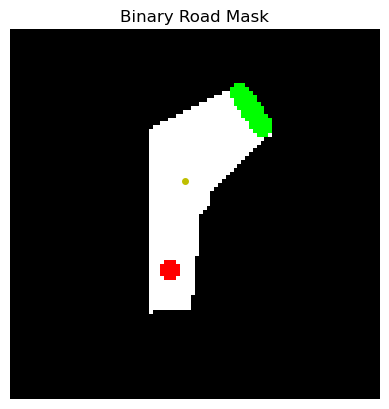

Reward: 195

150.167093218203

-30.0

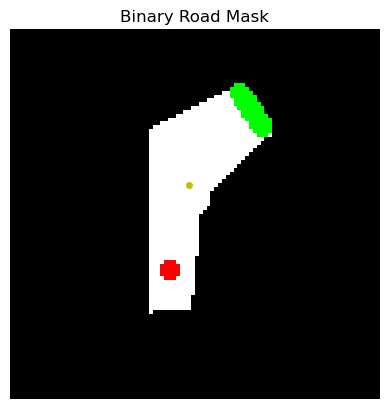

Reward: 194

-260.4951799236369

30.0

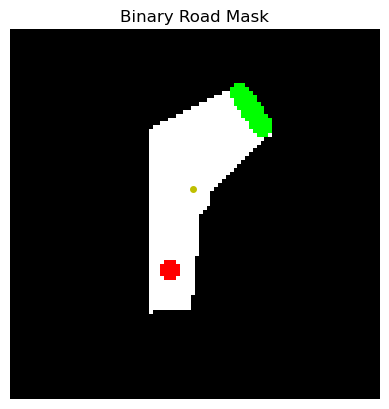

Reward: 193

177.39745236194472

-2.80244842171669

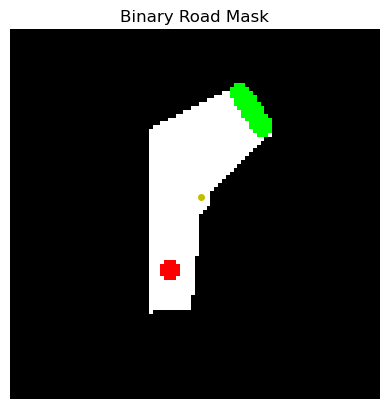

Reward: 192

-44.06176699042854

25.39575219154358

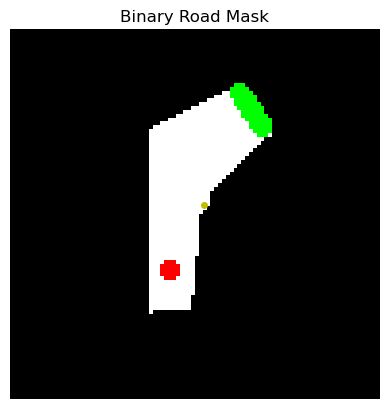

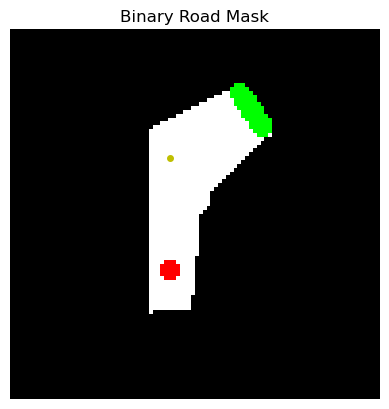

Reward: 200

-133.32154669345744

23.270722031593323

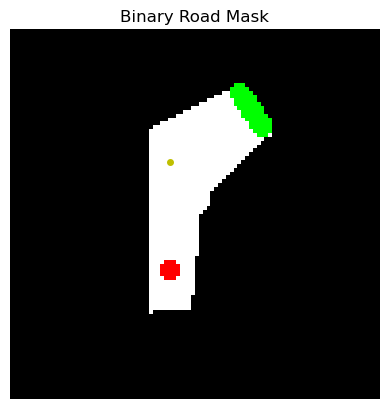

Reward: 199

56.87112934620532

30.0

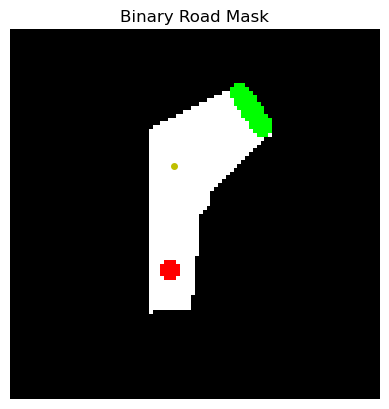

Reward: 198

-205.9601553941102

30.0

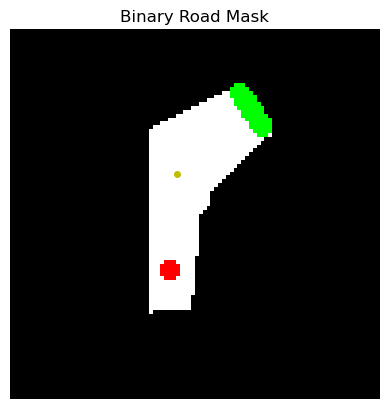

Reward: 197

-56.28072497876167

-30.0

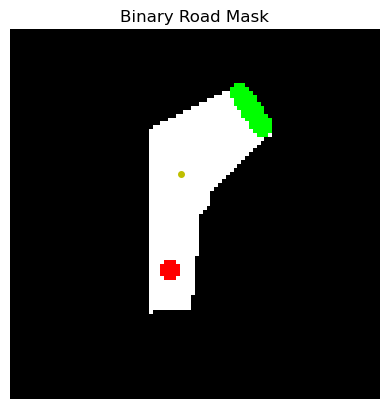

Reward: 196

239.7189177427949

-30.0

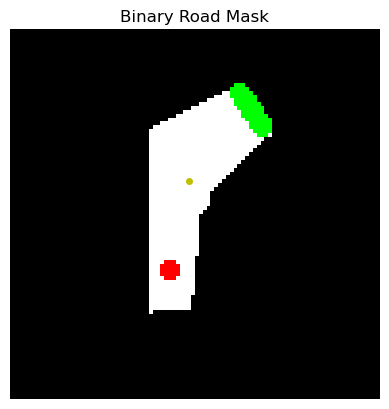

Reward: 195

177.27084784473354

-6.647359281778336

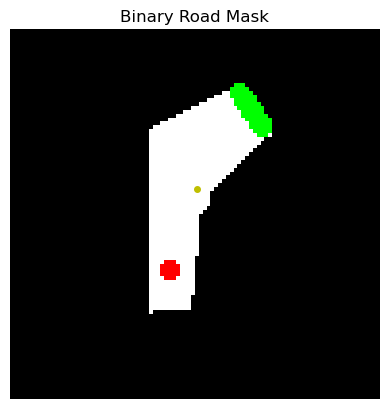

Reward: 194

-147.52959276916772

30.0

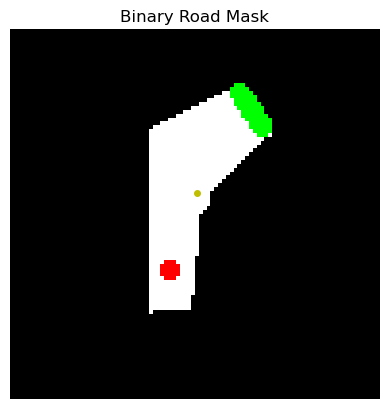

Reward: 193

-228.4001355074289

26.662752628326416

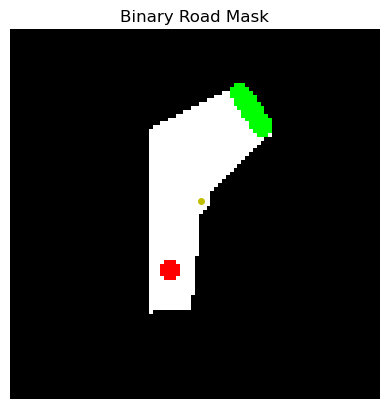

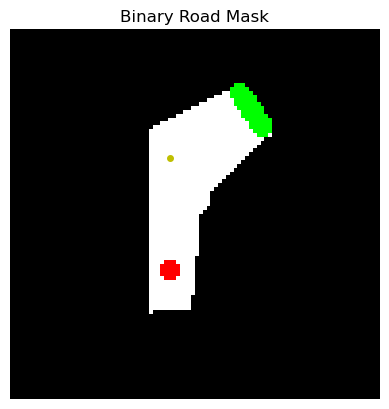

Reward: 200

-18.987611174959994

-30.0

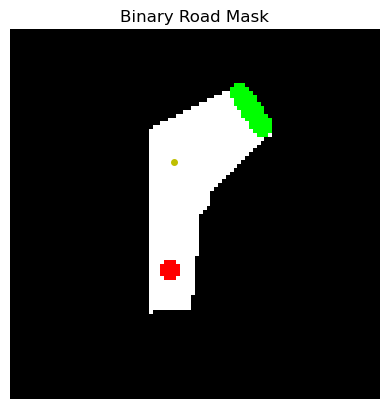

Reward: 199

-232.2769103229939

30.0

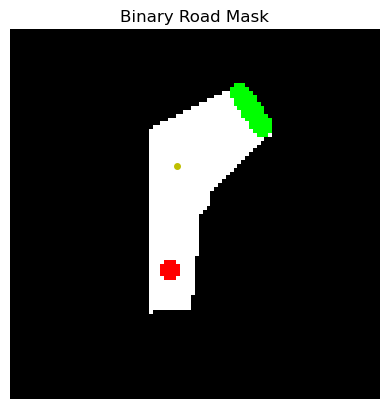

Reward: 198

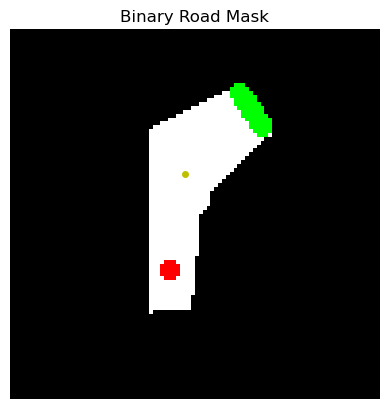

Reward: 197

-218.20028596399303

30.0

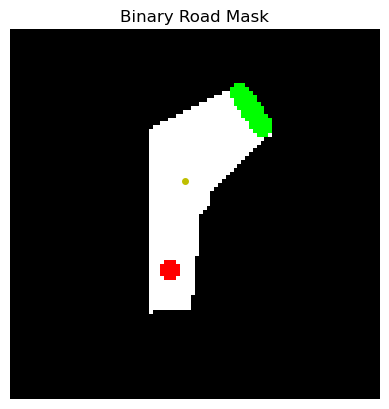

Reward: 196

138.6225769023058

-8.074979782104492

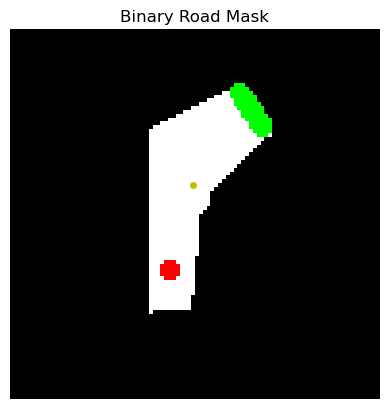

Reward: 195

-7.055688664144128

8.267555236816406

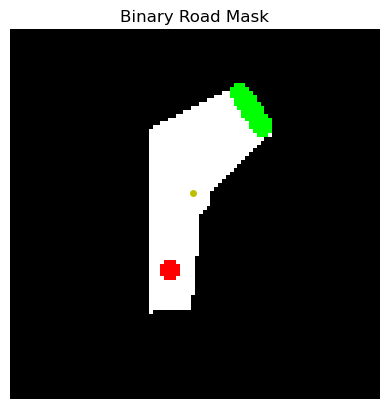

Reward: 194

-163.59700900098508

6.700397282838821

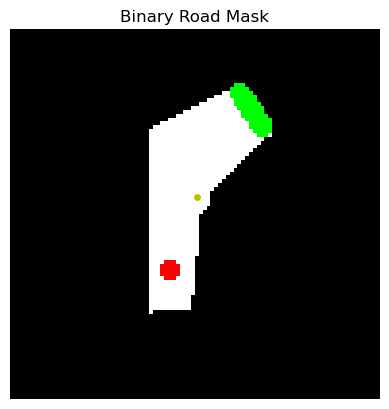

Reward: 193

-189.02221317527037

12.001731991767883

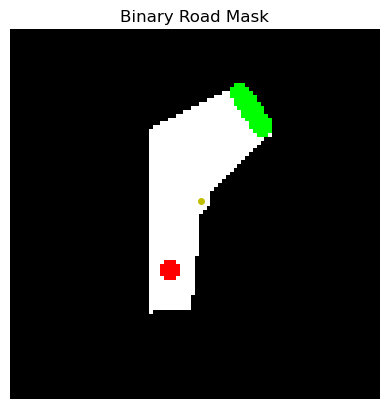

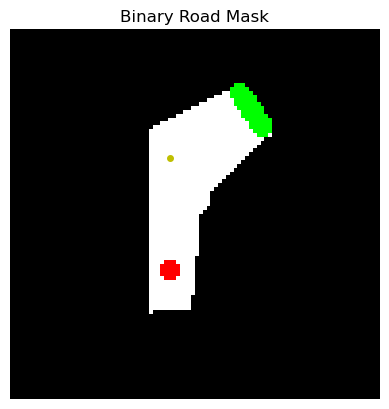

Reward: 200

-18.94400074831526

-30.0

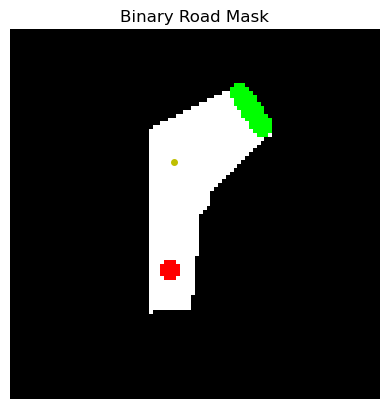

Reward: 199

-50.69098806981236

-9.573744535446167

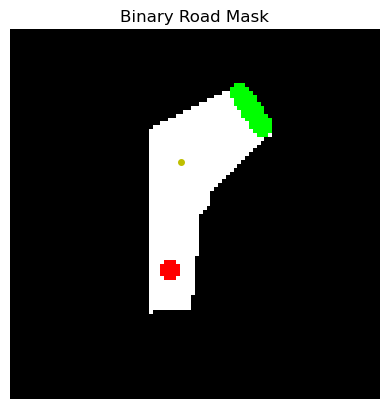

Reward: 198

-2.976749650737972

-20.976072549819946

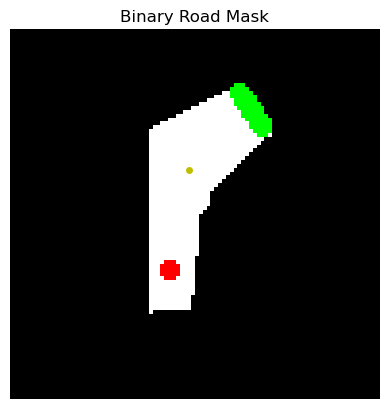

Reward: 197

52.732011248502204

25.246667861938477

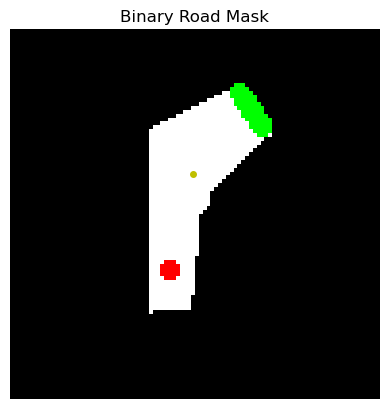

Reward: 196

-83.1141532987168

30.0

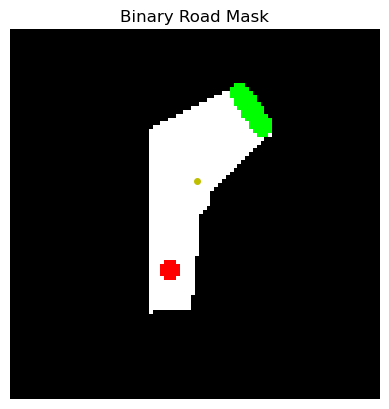

Reward: 195

53.517959276048884

30.0

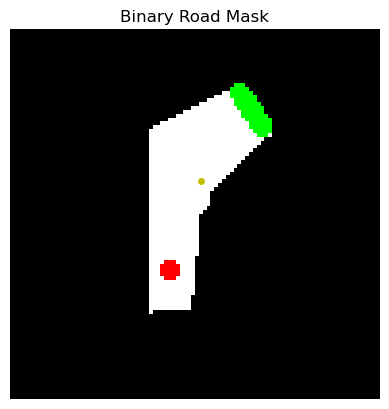

Reward: 194

50.78903774489149

-30.0

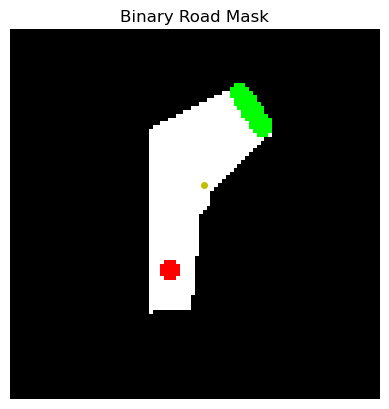

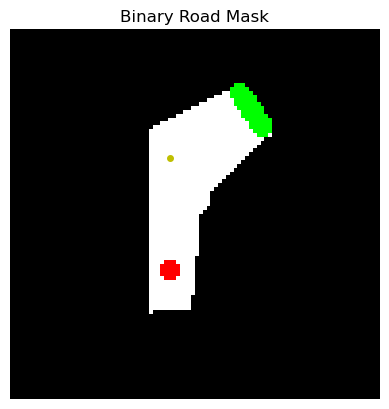

Reward: 200

53.71622740247324

26.534875631332397

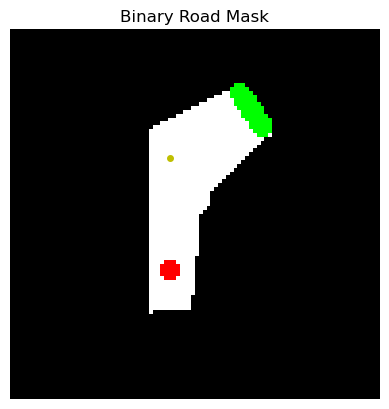

Reward: 199

-25.151603749452335

-18.9566570520401

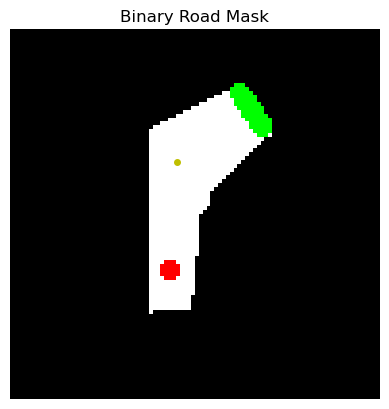

Reward: 198

-15.697689017484578

-9.038645625114441

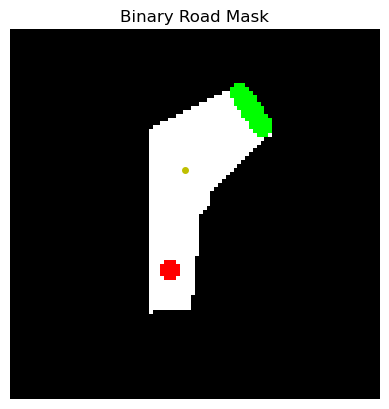

Reward: 197

71.33871413052407

0.5932436138391495

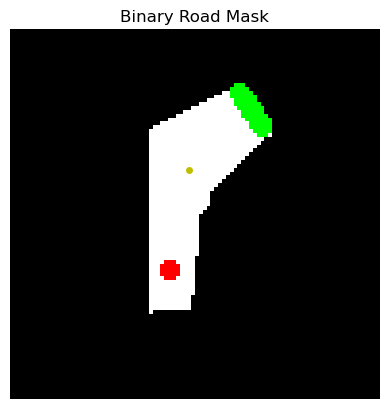

Reward: 196

41.64810775785949

13.56960654258728

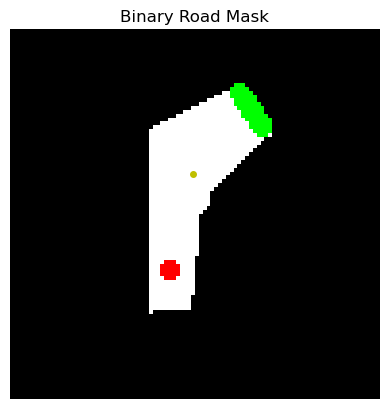

Reward: 195

-152.82087488534404

27.299718260765076

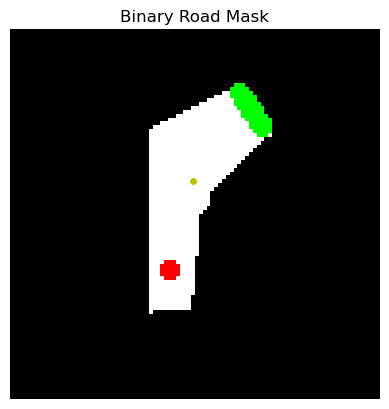

Reward: 194

-42.16563233887666

22.63806939125061

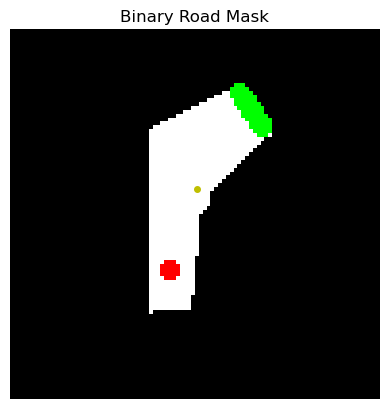

Reward: 193

81.29454481760506

-2.89786733686924

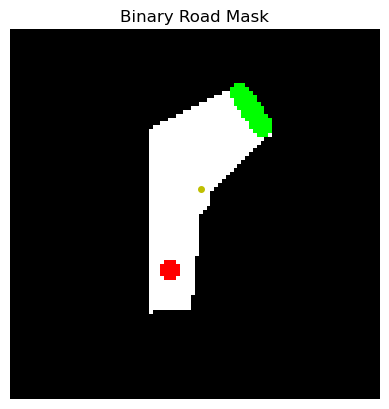

Reward: 192

-18.068547493859185

-21.2780624628067

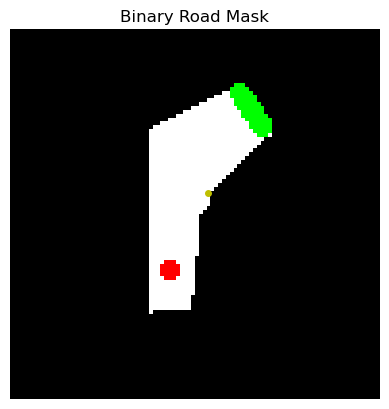

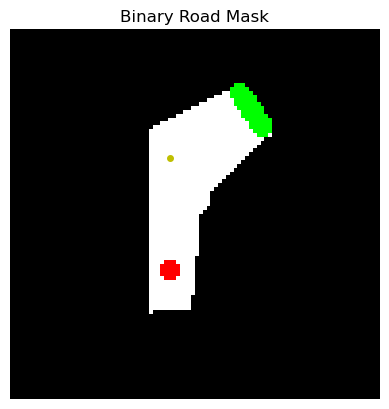

Reward: 200

201.90389280472098

-19.86108899116516

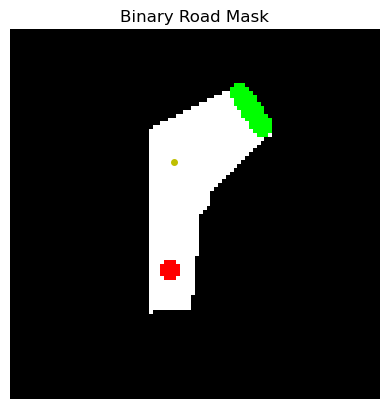

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 7.96          |
|    ep_rew_mean          | 1.56e+03      |
| time/                   |               |
|    fps                  | 24            |
|    iterations           | 4             |
|    time_elapsed         | 8             |
|    total_timesteps      | 200           |
| train/                  |               |
|    approx_kl            | 0.00071084616 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.83         |
|    explained_variance   | 1.19e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 3.5e+05       |
|    n_updates            | 30            |
|    policy_gradient_loss | -0.000358     |
|    std                  | 0.997         |
|    value_loss           | 7e+05         |
-------------------------------------------


Reward: 199

-204.5545329364615

16.93745791912079

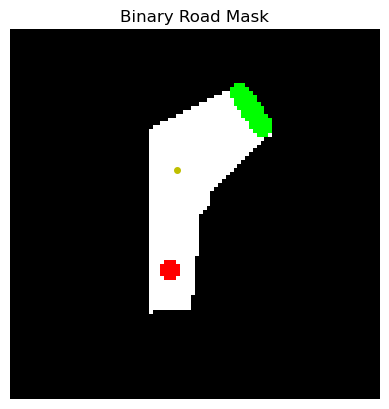

Reward: 198

-61.77567618699979

-0.08560091257095337

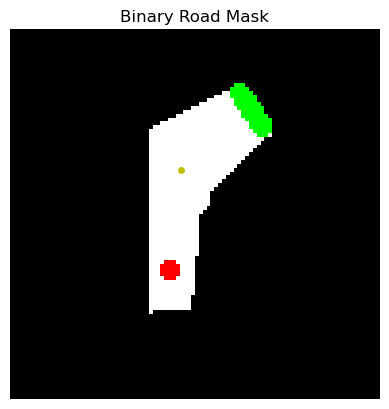

Reward: 197

-269.3978971633265

15.591675639152527

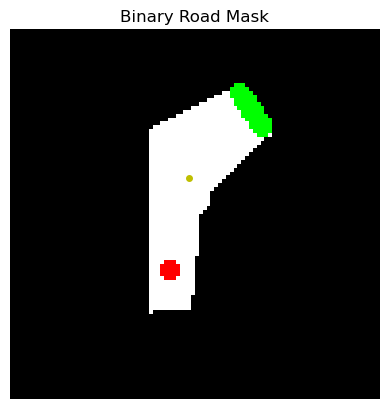

Reward: 196

142.70897284099695

-19.637900590896606

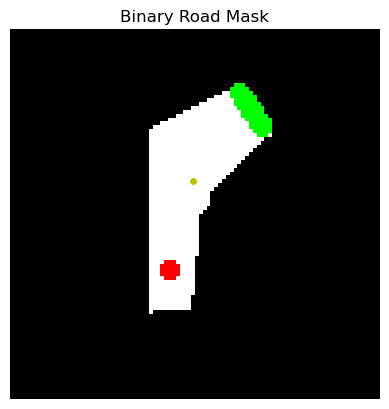

Reward: 195

120.98876939856086

-30.0

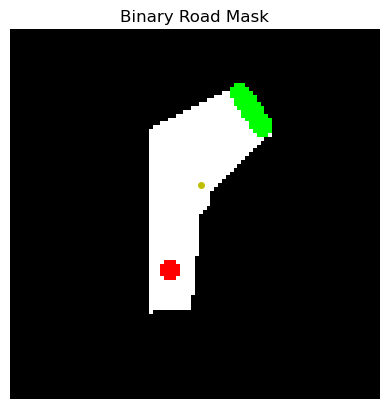

Reward: 194

-43.487218018547196

-30.0

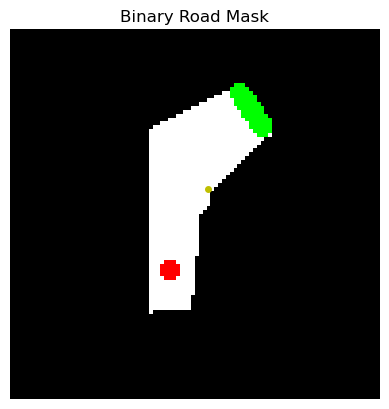

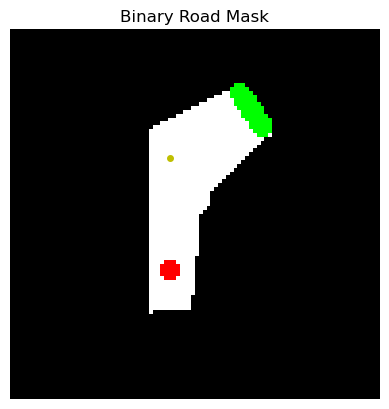

Reward: 200

-18.97303147873926

-30.0

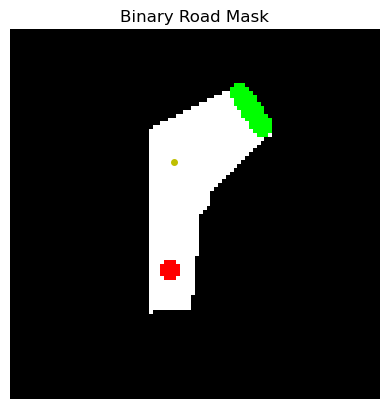

Reward: 199

-238.54546016675525

11.02645754814148

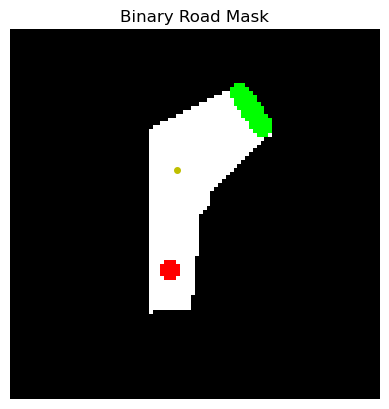

Reward: 198

-212.0150165235167

30.0

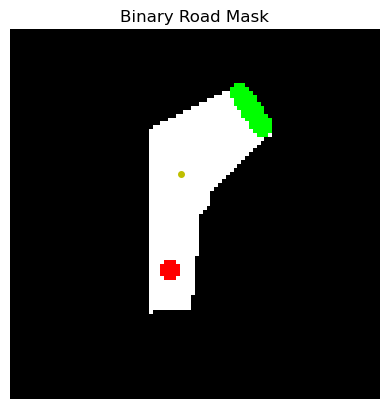

Reward: 197

-131.96663701827737

30.0

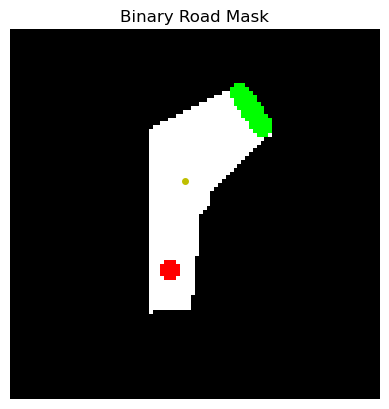

Reward: 196

257.2394700026259

-4.273779094219208

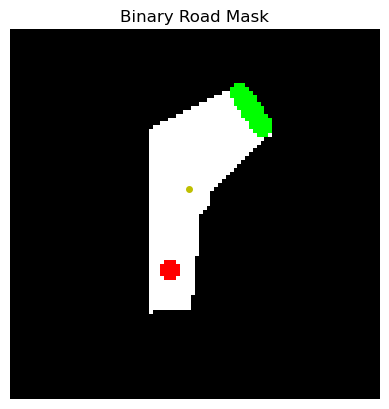

Reward: 195

-245.69988774166737

30.0

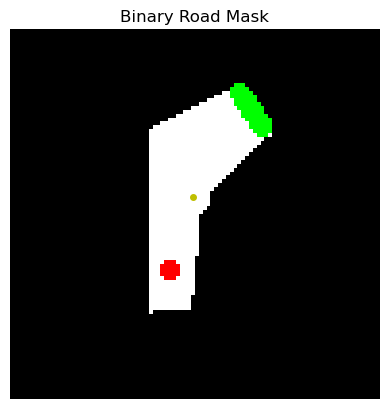

Reward: 194

-261.9593958895898

30.0

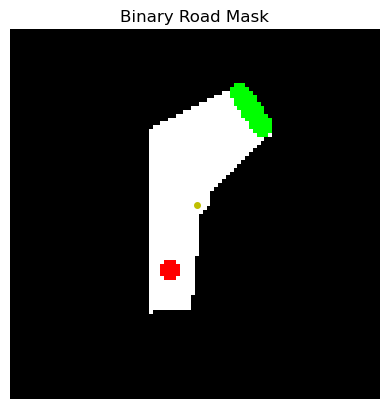

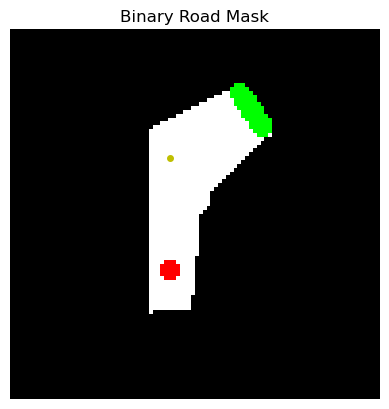

Reward: 200

-107.81568689686698

30.0

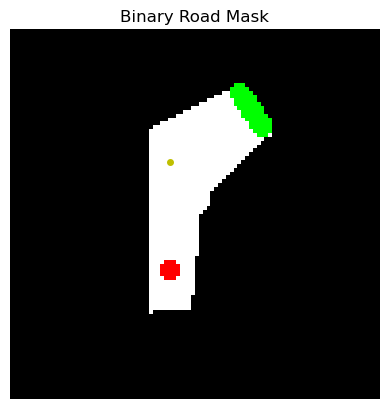

Reward: 199

-262.3330913338117

24.056646823883057

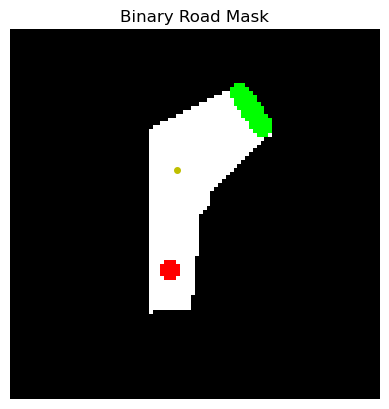

Reward: 198

-20.15812897471791

-23.26233208179474

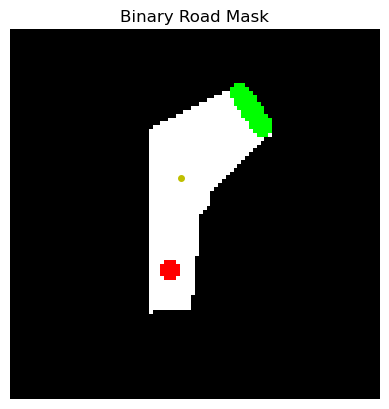

Reward: 197

149.46012994256304

-30.0

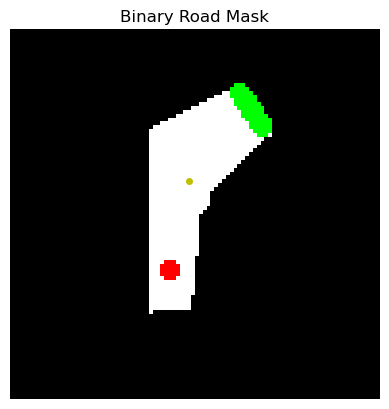

Reward: 196

59.03662810239655

30.0

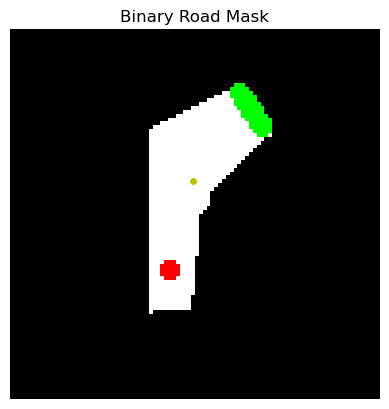

Reward: 195

7.981772442620979

19.000918865203857

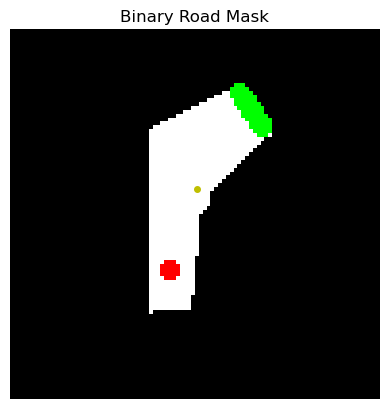

Reward: 194

-38.24710501962872

-30.0

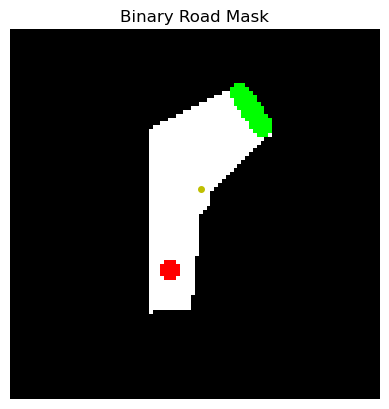

Reward: 193

-82.74408351944422

-22.246586680412292

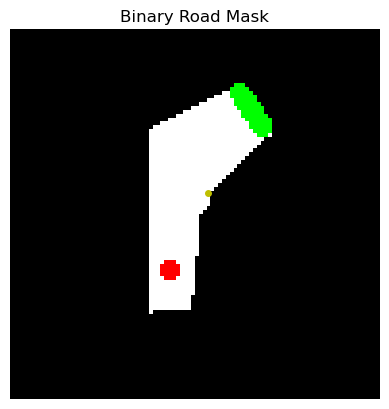

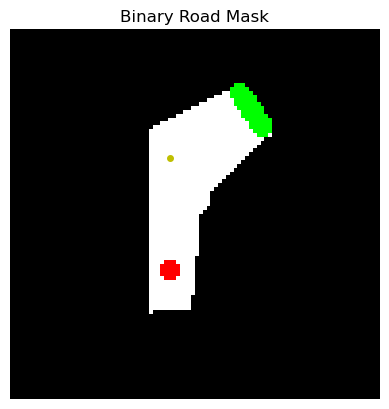

Reward: 200

-48.586731664294774

18.466166853904724

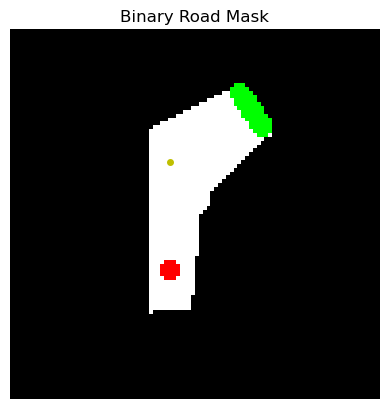

Reward: 199

-18.199960936447653

-17.063425183296204

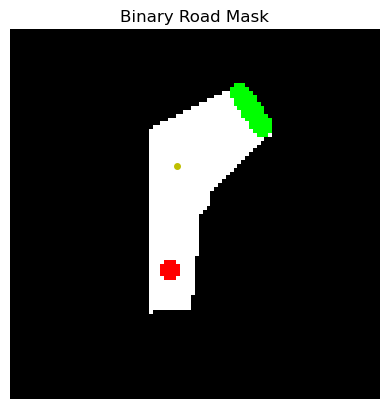

Reward: 198

-221.4314640475103

29.401638507843018

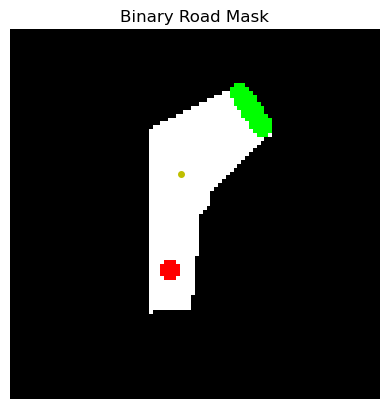

Reward: 197

137.29092304489623

-30.0

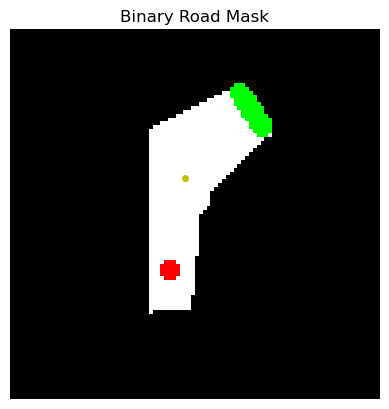

Reward: 196

190.79931028567808

-10.797243118286133

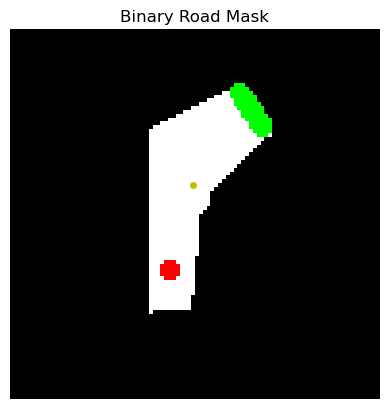

Reward: 195

-125.66858384152376

10.569460988044739

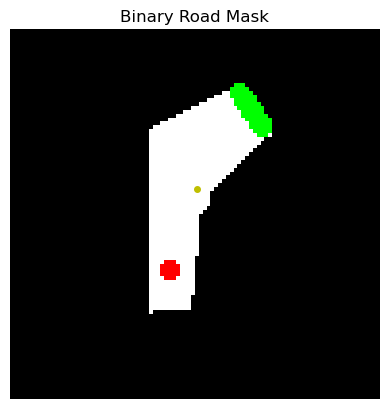

Reward: 194

-193.33139132977612

24.263364672660828

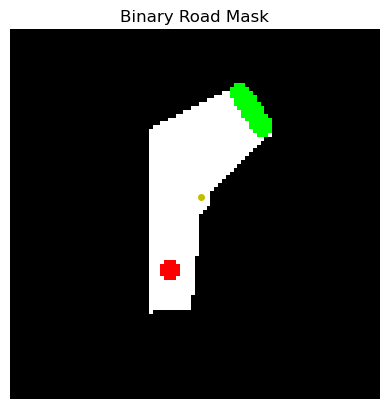

Reward: 193

-52.68894090910254

-30.0

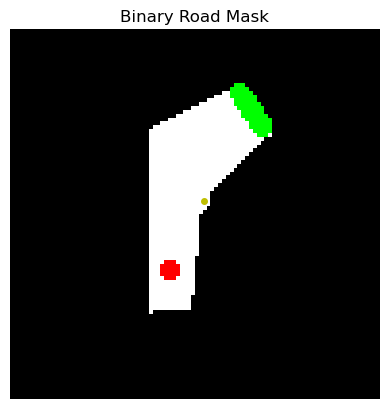

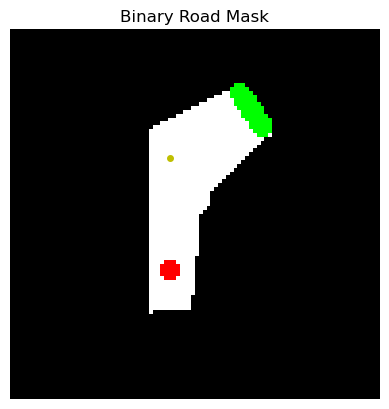

Reward: 200

-107.76250693075676

30.0

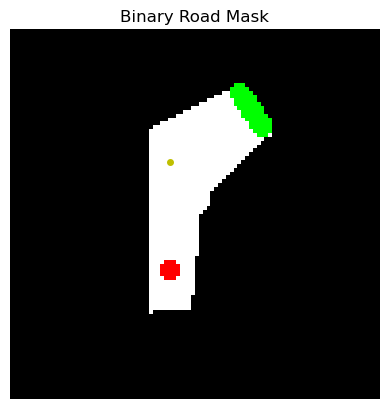

Reward: 199

-205.57910562465884

12.42671012878418

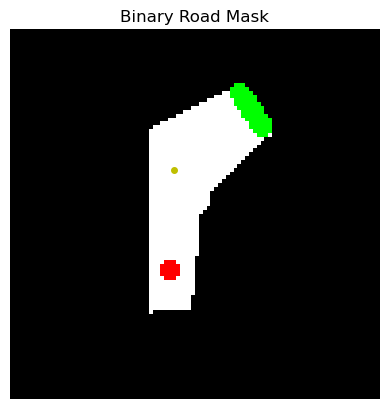

Reward: 198

120.93292575427536

-27.2891628742218

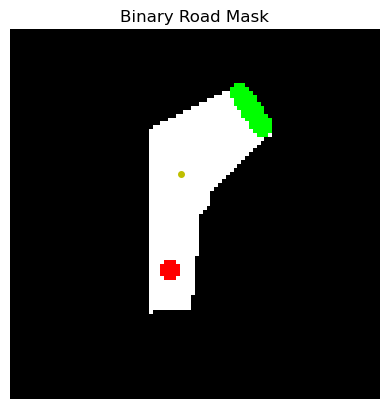

Reward: 197

-46.61790703680944

-30.0

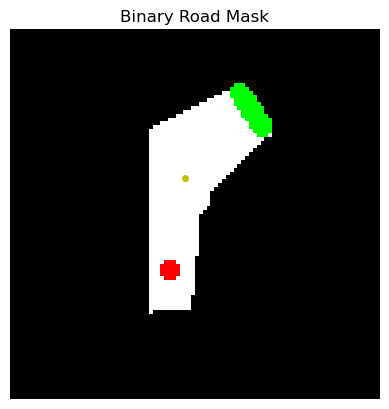

Reward: 196

-36.422406454866206

-6.783529222011566

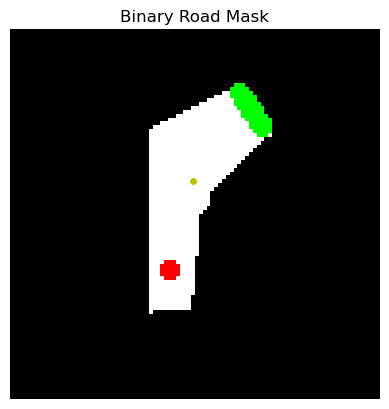

Reward: 195

-89.87635878624091

12.221041917800903

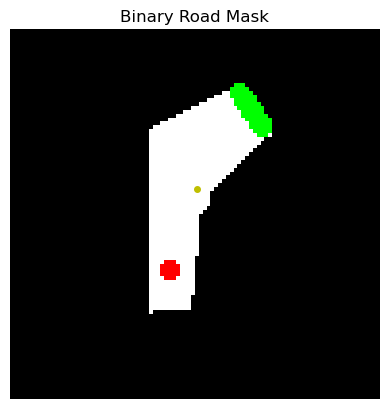

Reward: 194

114.83089050720973

-30.0

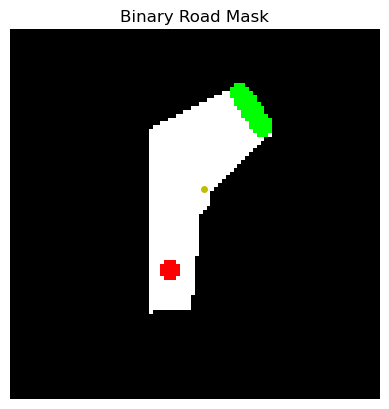

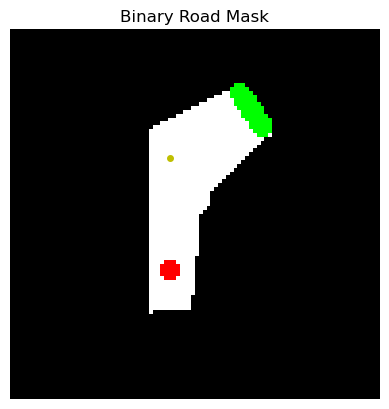

Reward: 200

-107.81568689686698

30.0

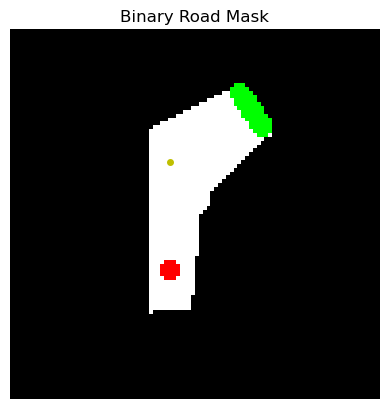

Reward: 199

49.37058686872264

-6.920206546783447

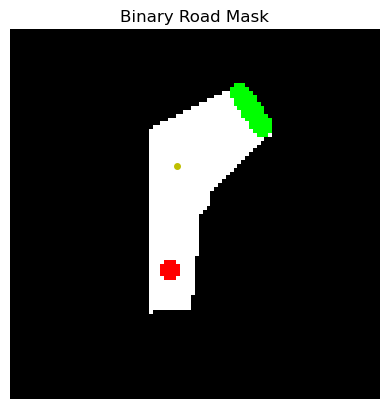

Reward: 198

19.82446883684638

-26.391858458518982

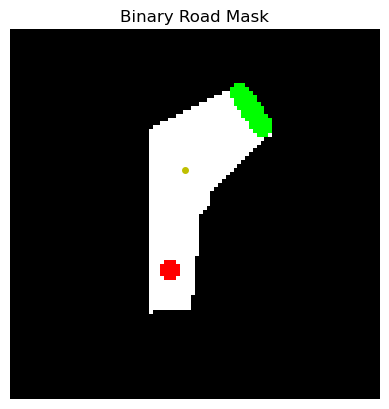

Reward: 197

-79.76099770176361

-30.0

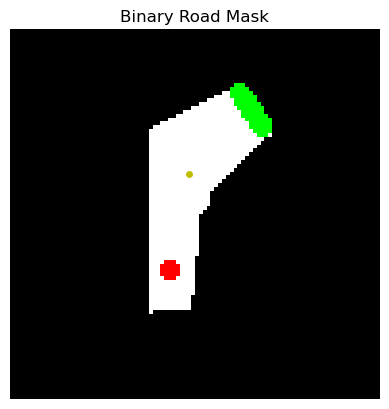

Reward: 196

-114.33546502606026

30.0

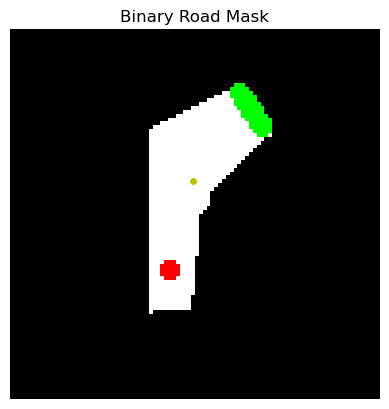

Reward: 195

147.30850128313804

-17.540525794029236

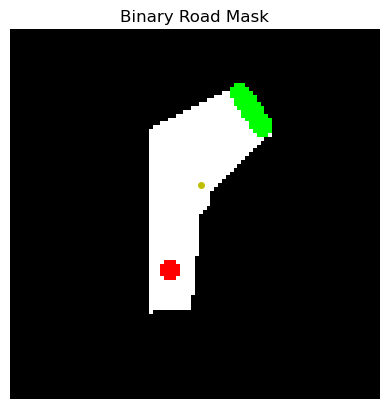

Reward: 194

-66.93419036764186

-12.746948003768921

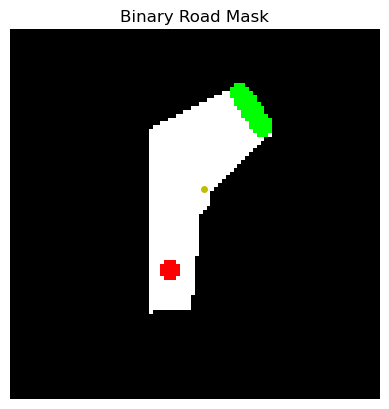

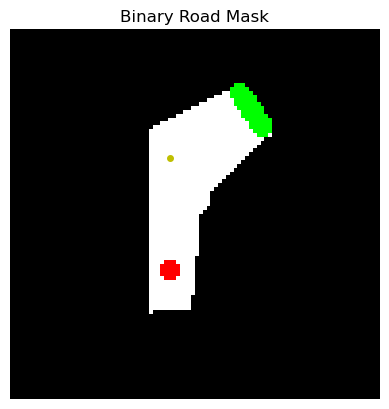

Reward: 200

-8.767821633387626

19.16113793849945

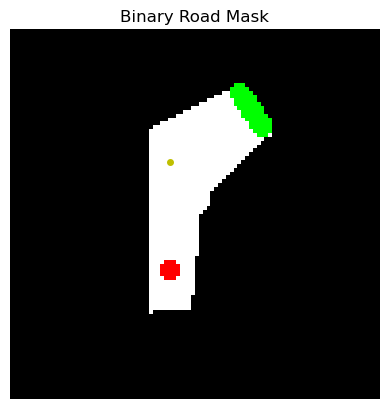

Reward: 199

-48.92484509645962

-19.71919298171997

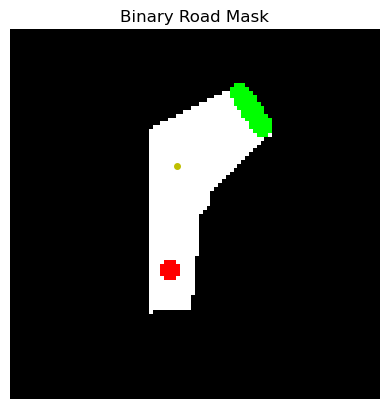

Reward: 198

-58.82021039610902

-30.0

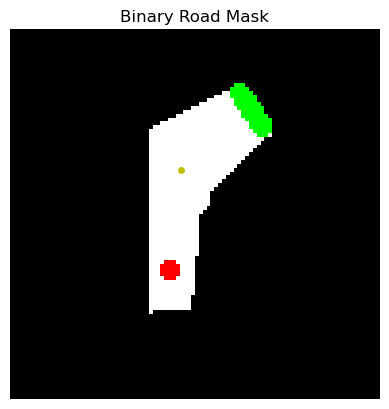

Reward: 197

67.83560957758266

-5.327872931957245

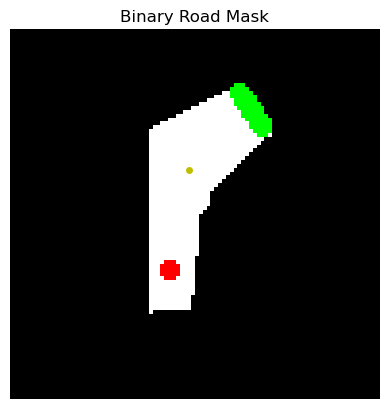

Reward: 196

152.4757327487548

-11.126081049442291

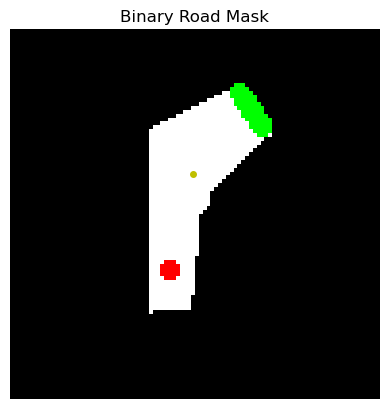

Reward: 195

79.65002363592498

-9.072330594062805

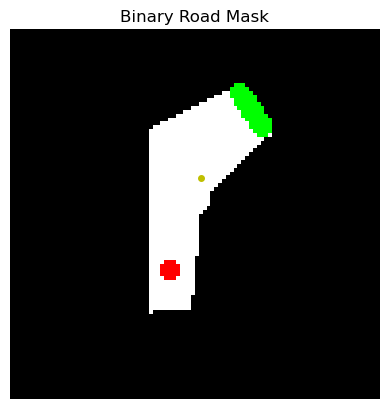

Reward: 194

17.506908478831022

-0.1630765199661255

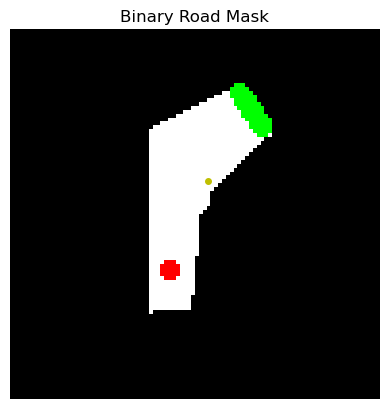

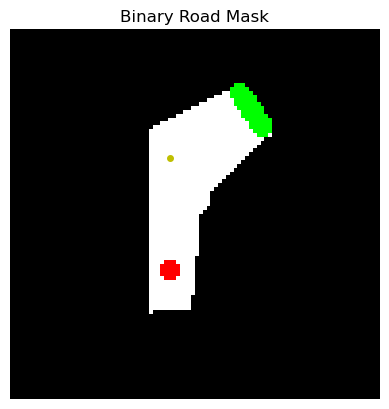

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.81         |
|    ep_rew_mean          | 1.53e+03     |
| time/                   |              |
|    fps                  | 24           |
|    iterations           | 5            |
|    time_elapsed         | 10           |
|    total_timesteps      | 250          |
| train/                  |              |
|    approx_kl            | 0.0001263392 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.83        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 3.6e+05      |
|    n_updates            | 40           |
|    policy_gradient_loss | -0.000118    |
|    std                  | 0.997        |
|    value_loss           | 7.2e+05      |
------------------------------------------


In [19]:
env.reset()
model.learn(total_timesteps=250, progress_bar=True, )


## Save Model